In [10]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_formatting import *
from collections import Counter
import numpy as np
import time

import json
import urllib.request

import pandas as pd
import datetime as dt
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import ticker
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mtick

from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools as it

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rc('axes', axisbelow=True)
%matplotlib inline

In [3]:
today = time.strftime("%Y-%m-%d")

month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}

weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-06', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATERANGE = DATE_DF['date'].tolist()

date_dict = {DATERANGE[i]:i for i in range(len(DATERANGE))}

In [4]:
nyt_data_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
ll = pd.read_csv(nyt_data_url, delimiter=',', dtype={'fips':str, 'cases':int, 'deaths':int})
ll = ll.sort_values(['date','state'])
ll = ll.dropna().reset_index().iloc[:,1:]

states = ll.state.unique().tolist()
dates = ll.date.unique().tolist()
ld = ll.date.unique().tolist()[-1]
fd = ll.date.unique().tolist()[0]
ld = month_dict[ld[5:7]]+" "+ld[-2:]+", "+ld[:4]
fd = month_dict[fd[5:7]]+" "+fd[-2:]+", "+fd[:4]

state_pop = pd.read_csv('https://raw.githubusercontent.com/CivilServiceUSA/us-states/master/data/states.csv')
state_pop = state_pop[['state','population']].copy()
extra_states = ['District of Columbia','United States','Puerto Rico','Virgin Islands',
                'Guam','Northern Mariana Islands']
extra_populs = [692683,330854067,3193694,106631,167294,57216]
state_pop = pd.concat([state_pop,
                       pd.DataFrame({'state':extra_states,
                                     'population':extra_populs})]).reset_index().iloc[:,1:]

ll = ll.merge(state_pop, how='left', on='state')

usa_ll = ll.groupby(['date']).agg({'cases':'sum','deaths':'sum','population':'sum'}).reset_index()
usa_ll['state'] = 'United States'
usa_ll['fips'] = '00'
usa_ll = usa_ll[['date', 'state', 'fips', 'cases', 'deaths', 'population']]
usa_ll['population'] = np.nanmax(usa_ll['population'])
ll = pd.concat([usa_ll,ll]).sort_values(['date','state']).reset_index().iloc[:,1:]

ll_df = ll.copy()

anomalous_deaths = {'New Jersey':{'date':'2020-06-24','deaths':1854},
                    'Delaware':{'date':'2020-06-22','deaths':69},
                    'Colorado':{'date':'2020-04-24','deaths':85},
                    'Massachusetts':{'date':'2020-06-01','deaths':100},
                    'New York':{'date':'2020-06-30','deaths':600},
                    'Michigan':{'date':'2020-06-05','deaths':225},
                    'Ohio':{'date':'2021-02-12','deaths':2500},
                    'United States':{'date':'2020-06-24','deaths':1923}}

anomalous_cases = {'New Jersey':{'date':'2020-06-24','cases':1798},
                   'Colorado':{'date':'2020-04-24','cases':609},
                   'Massachusetts':{'date':'2020-06-01','cases':3176},
                   'Texas':{'date':'2020-09-21','cases':16000},
                   'Michigan':{'date':'2020-06-05','cases':4000},
                   'Georgia':{'date':'2020-10-05','cases':20000},
                   'Wisconsin':{'date':'2020-06-10','cases':2426}}

state_df = []
for st in ll.state.unique():
    ll_st = ll.loc[ll['state']==st].copy()
    total_deaths_st = ll_st['deaths'].values[-1]
    total_cases_st = ll_st['cases'].values[-1]

    if st in list(anomalous_deaths.keys()):
        curr = ll_st.loc[ll_st['date'] >= anomalous_deaths[st]['date'], 'deaths'].values -\
                                          anomalous_deaths[st]['deaths']
        ll_st.loc[ll_st['date'] >= anomalous_deaths[st]['date'], 'deaths'] = curr
        prev = ll_st.loc[ll_st['date'] <= anomalous_deaths[st]['date'], 'deaths'].values
        tmp_prev = np.diff(sorted(prev),prepend=[0])
        p_vals = tmp_prev / tmp_prev.sum()
        add_vals = np.random.multinomial(anomalous_deaths[st]['deaths'], p_vals)
        prev = list(tmp_prev + add_vals)
        tots = list(np.cumsum(prev))+list(curr+anomalous_deaths[st]['deaths'])[1:]
        ll_st['deaths'] = tots
        if st == 'Ohio':
            anomalous_deaths = {'New Jersey':{'date':'2020-06-24','deaths':1854},
                                'Delaware':{'date':'2020-07-24','deaths':45},
                                'Colorado':{'date':'2020-04-24','deaths':85},
                                'Massachusetts':{'date':'2020-06-01','deaths':100},
                                'New York':{'date':'2020-06-30','deaths':600},
                                'Michigan':{'date':'2020-06-05','deaths':225},
                                'Ohio':{'date':'2021-02-13','deaths':1170},
                                'United States':{'date':'2020-06-24','deaths':1923}}
            curr = ll_st.loc[ll_st['date'] >= anomalous_deaths[st]['date'], 'deaths'].values -\
                                              anomalous_deaths[st]['deaths']
            ll_st.loc[ll_st['date'] >= anomalous_deaths[st]['date'], 'deaths'] = curr
            prev = ll_st.loc[ll_st['date'] <= anomalous_deaths[st]['date'], 'deaths'].values
            tmp_prev = np.diff(sorted(prev),prepend=[0])
            p_vals = tmp_prev / tmp_prev.sum()
            add_vals = np.random.multinomial(anomalous_deaths[st]['deaths'], p_vals)
            prev = list(tmp_prev + add_vals)
            tots = list(np.cumsum(prev))+list(curr+anomalous_deaths[st]['deaths'])[1:]
            ll_st['deaths'] = tots

        if st == 'Ohio':
            anomalous_deaths = {'New Jersey':{'date':'2020-06-24','deaths':1854},
                                'Delaware':{'date':'2020-07-24','deaths':45},
                                'Colorado':{'date':'2020-04-24','deaths':85},
                                'Massachusetts':{'date':'2020-06-01','deaths':100},
                                'New York':{'date':'2020-06-30','deaths':600},
                                'Michigan':{'date':'2020-06-05','deaths':225},
                                'Ohio':{'date':'2021-02-11','deaths':680},
                                'United States':{'date':'2020-06-24','deaths':1923}}
            curr = ll_st.loc[ll_st['date'] >= anomalous_deaths[st]['date'], 'deaths'].values -\
                                              anomalous_deaths[st]['deaths']
            ll_st.loc[ll_st['date'] >= anomalous_deaths[st]['date'], 'deaths'] = curr
            prev = ll_st.loc[ll_st['date'] <= anomalous_deaths[st]['date'], 'deaths'].values
            tmp_prev = np.diff(sorted(prev),prepend=[0])
            p_vals = tmp_prev / tmp_prev.sum()
            add_vals = np.random.multinomial(anomalous_deaths[st]['deaths'], p_vals)
            prev = list(tmp_prev + add_vals)
            tots = list(np.cumsum(prev))+list(curr+anomalous_deaths[st]['deaths'])[1:]
            ll_st['deaths'] = tots

        if st == 'Delaware':
            anomalous_deaths = {'New Jersey':{'date':'2020-06-24','deaths':1854},
                                'Delaware':{'date':'2020-07-24','deaths':45},
                                'Colorado':{'date':'2020-04-24','deaths':85},
                                'Massachusetts':{'date':'2020-06-01','deaths':100},
                                'New York':{'date':'2020-06-30','deaths':600},
                                'Michigan':{'date':'2020-06-05','deaths':225},
                                'Ohio':{'date':'2021-02-12','deaths':2500},
                                'United States':{'date':'2020-06-24','deaths':1923}}
            curr = ll_st.loc[ll_st['date'] >= anomalous_deaths[st]['date'], 'deaths'].values -\
                                              anomalous_deaths[st]['deaths']
            ll_st.loc[ll_st['date'] >= anomalous_deaths[st]['date'], 'deaths'] = curr
            prev = ll_st.loc[ll_st['date'] <= anomalous_deaths[st]['date'], 'deaths'].values
            tmp_prev = np.diff(sorted(prev),prepend=[0])
            p_vals = tmp_prev / tmp_prev.sum()
            add_vals = np.random.multinomial(anomalous_deaths[st]['deaths'], p_vals)
            prev = list(tmp_prev + add_vals)
            tots = list(np.cumsum(prev))+list(curr+anomalous_deaths[st]['deaths'])[1:]
            ll_st['deaths'] = tots
            
    
    if st in list(anomalous_cases.keys()):
        curr = ll_st.loc[ll_st['date'] >= anomalous_cases[st]['date'], 'cases'].values -\
                                          anomalous_cases[st]['cases']
        ll_st.loc[ll_st['date'] >= anomalous_cases[st]['date'], 'cases'] = curr
        prev = ll_st.loc[ll_st['date'] <= anomalous_cases[st]['date'], 'cases'].values
        tmp_prev = np.diff(sorted(prev),prepend=[0])
        p_vals = tmp_prev / tmp_prev.sum()
        add_vals = np.random.multinomial(anomalous_cases[st]['cases'], p_vals)
        prev = list(tmp_prev + add_vals)
        tots = list(np.cumsum(prev))+list(curr+anomalous_cases[st]['cases'])[1:]
        ll_st['cases'] = tots

    ll_st['new_cases'] = list(np.nan_to_num(ll_st['cases'].diff().tolist()).astype(int))
    ll_st['new_deaths'] = list(np.nan_to_num(ll_st['deaths'].diff().tolist()).astype(int))

    ll_st.loc[ll_st['new_cases']<0,'new_cases'] = 0
    ll_st.loc[ll_st['new_deaths']<0,'new_deaths'] = 0
    state_df.append(ll_st)

ll = pd.concat(state_df).sort_values(['date','state']).reset_index().iloc[:,1:]

ll['new_cases_per_1000'] = (ll['new_cases'] / ll['population'] * 1000).round(7)
ll['new_deaths_per_1000'] = (ll['new_deaths'] / ll['population'] * 1000).round(7)
ll['cases_per_1000'] = (ll['cases'] / ll['population'] * 1000).round(7)
ll['deaths_per_1000'] = (ll['deaths'] / ll['population'] * 1000).round(7)
ll = ll.merge(DATE_DF[['date','week']], how='left', on='date')

ll.tail()


,date,state,fips,cases,deaths,population,new_cases,new_deaths,new_cases_per_1000,new_deaths_per_1000,cases_per_1000,deaths_per_1000,week
21275,2021-03-16,Virginia,51,597141,10104,8260405,1276,44,0.154472,0.005327,72.289555,1.223185,62
21276,2021-03-16,Washington,53,353929,5206,6971406,637,14,0.091373,0.002008,50.768668,0.746765,62
21277,2021-03-16,West Virginia,54,136019,2546,1854304,341,15,0.183896,0.008089,73.353129,1.373022,62
21278,2021-03-16,Wisconsin,55,626537,7184,5742713,649,5,0.113013,0.000871,109.101221,1.250977,62
21279,2021-03-16,Wyoming,56,55352,693,582658,25,2,0.042907,0.003432,94.999125,1.189377,62


In [5]:
# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('../client_secret.json', scope)
client = gspread.authorize(creds)

In [6]:
usr_agent = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) '
                  'Chrome/61.0.3163.100 Safari/537.36'}

# Alabama

https://alpublichealth.maps.arcgis.com/apps/opsdashboard/index.html#/c6909b3820ae4047b0317fa00abc46fc

In [60]:
al_url2 = 'https://services7.arcgis.com/4RQmZZ0yaZkGR1zy/arcgis/rest/services/alsde_c19_publish_PUBLIC/FeatureServer/0/query?f=json&where=WeekOf%3D11&returnGeometry=false&spatialRel=esriSpatialRelIntersects&outFields=*&orderByFields=SchoolSystem%20asc&outSR=102100&resultOffset=0&resultRecordCount=150&resultType=standard&cacheHint=true'

In [52]:
al_df1 = pd.read_csv('../data/alabama_schools.csv')

In [54]:
with urllib.request.urlopen(al_url2) as url_i:
    al_page2 = json.loads(url_i.read().decode())
    
al_df2 = pd.DataFrame([i['attributes'] for i in al_page2['features']])
al_df2['Submission_Date'] = pd.to_datetime(al_df2['Submission_Date']/1000,
                                           unit='s',utc=True).dt.strftime('%Y-%m-%d')
al_df2.loc[al_df2['Submission_Date'].isna(),
           'Submission_Date'] = al_df2.loc[~al_df2['Submission_Date'].isna(),
                                           'Submission_Date'].max()

In [58]:
al_df = pd.concat([al_df1, al_df2]).drop_duplicates()

In [59]:
# al_df.to_csv('../data/alabama_schools.csv',index=False)

# Alaska


# Arizona

https://www.azed.gov/covid-19/learning-model-tracker?page=1

In [63]:
# out_az = []
# for page_i in range(19):
#     az_school_url_i = 'https://www.azed.gov/covid-19/learning-model-tracker?page=%i'%page_i
#     page = requests.get(az_school_url_i)
#     soup = BeautifulSoup(page.content, 'html.parser')
#     tbl = soup.find("table",{"class":"views-table cols-3 table table-hover table-striped"})
#     df_tbl = pd.read_html(str(tbl))[0]
#     out_az.append(df_tbl)
    
# az_df_status = pd.concat(out_az).reset_index().iloc[:,1:]
# # az_df_status

In [64]:
# az_df_status.to_csv('../data/arizona_schools_status.csv',index=False)

# Arkansas

https://www.healthy.arkansas.gov/programs-services/topics/covid-19-reports

schools: https://www.healthy.arkansas.gov/images/uploads/pdf/School_Report_02252021.pdf

schools: https://www.healthy.arkansas.gov/images/uploads/pdf/School_Report_03012021.pdf

outbreaks: https://www.healthy.arkansas.gov/images/uploads/pdf/Active_COVID-19_report02252021.pdf

https://achi.net/covid19/

In [134]:
ar_data = client.open("COVID-data_Arkansas")
ar_df = ar_data.worksheet('schools')
ar_df = pd.DataFrame(ar_df.get_all_records(default_blank=np.nan))

ar_df['new_cases_students'] = ar_df['new_cases_students'].astype(float)
ar_df['new_cases_employee'] = ar_df['new_cases_employee'].astype(float)
ar_df['new_cases'] = ar_df['new_cases'].astype(float)

ar_df['total_cases_employee'] = ar_df['total_cases_employee'].astype(float)
ar_df['total_cases_students'] = ar_df['total_cases_students'].astype(float)
ar_df['total_cases'] = ar_df['total_cases'].astype(float)
min_d = ar_df['date'].min()
max_d = ar_df['date'].max()
ar_df_out = []
for x in ar_df.name.unique():
    dat_x = ar_df.loc[ar_df['name']==x].copy()
    dat_x = DATE_DF.loc[(DATE_DF['date']>=min_d)&\
                        (DATE_DF['date']<=max_d)][['date',
                                                   'week']].merge(dat_x,
                                                  how='left', on='date')
    dat_x['name'] = dat_x['name'].dropna().unique()[0]
    dat_x['type'] = dat_x['type'].dropna().unique()[0]
    dat_x['total_cases_employee'] = dat_x['total_cases_employee'].fillna(method='ffill')
    dat_x['total_cases_employee'] = dat_x['total_cases_employee'].fillna(method='bfill')
    dat_x['total_cases_students'] = dat_x['total_cases_students'].fillna(method='ffill')
    dat_x['total_cases_students'] = dat_x['total_cases_students'].fillna(method='bfill')
    dat_x['total_cases'] = dat_x['total_cases'].fillna(method='ffill')
    dat_x['total_cases'] = dat_x['total_cases'].fillna(method='bfill')
    dat_x['new_cases_students'] = dat_x['new_cases_students'].fillna(0)
    dat_x['new_cases_employee'] = dat_x['new_cases_employee'].fillna(0)
    dat_x['new_cases'] = dat_x['new_cases'].fillna(0)
    ar_df_out.append(dat_x)

ar_df = pd.concat(ar_df_out).reset_index().iloc[:,1:]
ar_df = ar_df.loc[ar_df['type']=='k12'].copy().reset_index().iloc[:,1:]

In [140]:
ar_dfg = ar_df.groupby('week').agg({'new_cases_employee':'sum',
                                    'new_cases_students':'sum',
                                    'new_cases':'sum',
                                    'date':'min'}).reset_index()
ll_ar_g = ll.loc[ll['state']=='Arkansas'].groupby(['week']).agg({'new_cases':'sum',
                                     'new_deaths':'sum', 'population':'mean'}).reset_index()
ll_ar_g = ll_ar_g.rename(columns={'new_cases':'new_cases_state',
                                  'new_deaths':'new_deaths_state',
                                  'population':'population_state'})
ar_dfg = ar_dfg.merge(ll_ar_g, how='left', on='week')

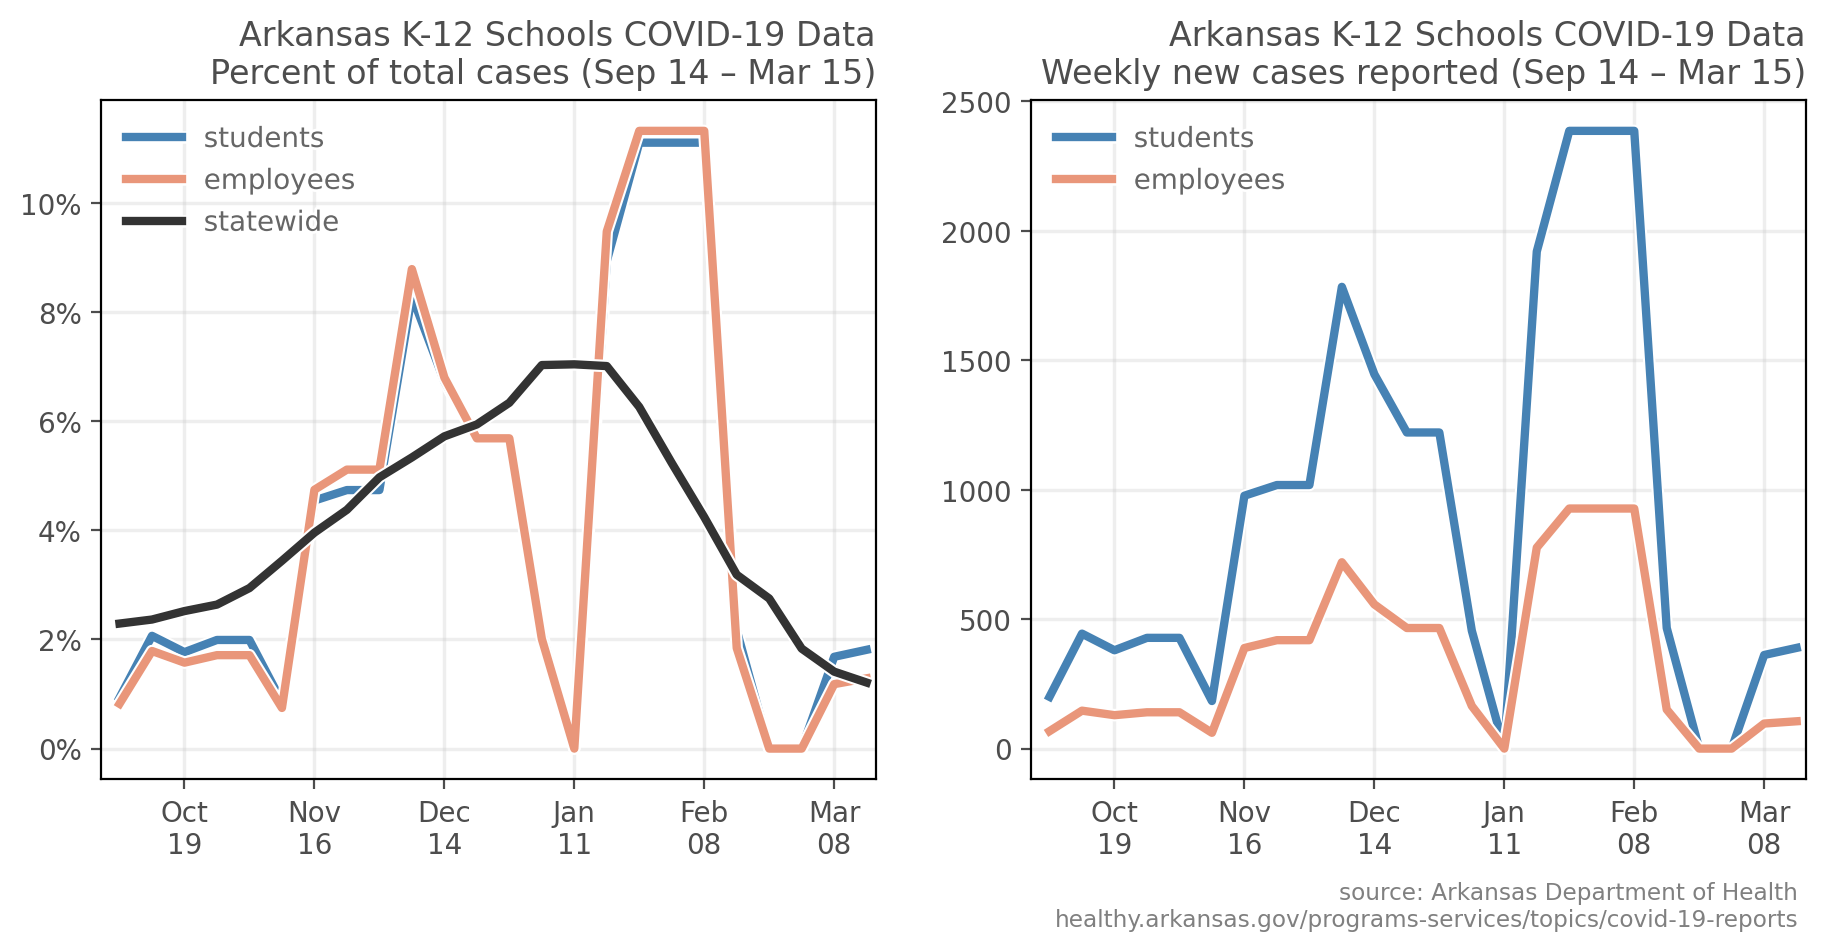

In [155]:
lw = 3
fig, ax = plt.subplots(1,2,figsize=(11,4.5),dpi=200)
wid = 4

labs_tx = ['students','employees','statewide']
cols = ['steelblue','darksalmon','.2']
for ci, col in enumerate(['new_cases_students','new_cases_employee','new_cases_state']):
    xvals_i = [date_dict[i] for i in ar_dfg['date'].values]
    yvals_i = ar_dfg[col].rolling(window=wid).mean().values
    ax[0].plot(xvals_i, yvals_i/np.nansum(yvals_i), label=labs_tx[ci], lw=lw, color=cols[ci],
            path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                          path_effects.Normal()])
    if ci < 2:
        yvals_i = ar_dfg[col].rolling(window=wid).mean().values
        ax[1].plot(xvals_i, yvals_i, label=labs_tx[ci], lw=lw, color=cols[ci],
                path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                              path_effects.Normal()])



dates = sorted(ar_dfg['date'].values)[1::4]
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))
tlabs = ['Percent of total cases '+\
              '(%s %s – %s %s)'%(month_dict[ar_dfg['date'].min()[5:7]],
                                 ar_dfg['date'].min()[8:],
                                 month_dict[ar_dfg['date'].max()[5:7]],
                                 ar_dfg['date'].max()[8:]),
        'Weekly new cases reported '+\
              '(%s %s – %s %s)'%(month_dict[ar_dfg['date'].min()[5:7]],
                                 ar_dfg['date'].min()[8:],
                                 month_dict[ar_dfg['date'].max()[5:7]],
                                 ar_dfg['date'].max()[8:]),]

for ai,a in enumerate(fig.axes):
    a.set_xticks([date_dict[i] for i in dates])
    a.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates])
    l = a.legend(loc=2, ncol=1, framealpha=0)
    for text in l.get_texts():
        text.set_color('.4')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w'),
                               path_effects.Normal()])

    a.tick_params(labelcolor='.3', color='.3')
    a.grid(linewidth=1.25,color='.75',alpha=0.25)
    a.set_title('Arkansas K-12 Schools COVID-19 Data\n'+tlabs[ai],
                x=1,color='.3',ha='right')
    a.set_xlim(date_dict[ar_dfg['date'].min()]+17,
               date_dict[ar_dfg['date'].max()]+2)

ax[1].text(0.99,-0.15,'source: Arkansas Department of Health\n'+\
        'healthy.arkansas.gov/programs-services/topics/covid-19-reports',
        color='.5',fontsize='small', va='top', ha='right', transform=ax[1].transAxes)

plt.savefig('../figs/pngs/arkansas_k12_studentstaff.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/arkansas_k12_studentstaff.pdf',bbox_inches='tight')
plt.show()

# California

https://maps.schools.covid19.ca.gov/public.html

# Colorado

https://docs.google.com/spreadsheets/d/e/2PACX-1vQipdjO8QWhilhhJ4bX0FBebnHEzK1G3LEDQbE_S-xRvs2t0oHNm--acHwMRFmL9uKw4cXcOUqy1V66/pubhtml#

https://docs.google.com/spreadsheets/d/1Kjzhzb6Q608zSyVUVDWzpdIxspX1nKuf/edit#gid=2130177518

In [294]:
co_data = client.open("COVID-data_Colorado")
co_df = co_data.worksheet('schools')
co_df = pd.DataFrame(co_df.get_all_records(default_blank=np.nan))

co_df['total_deaths_employee'] = co_df['total_deaths_employee'].astype(float)
co_df['total_deaths_students'] = co_df['total_deaths_students'].astype(float)
co_df['total_cases_employee'] = co_df['total_cases_employee'].astype(float)
co_df['total_cases_students'] = co_df['total_cases_students'].astype(float)


min_d = co_df['date'].min()
max_d = co_df['date'].max()
co_df_out = []
for x in co_df.name.unique():
    dat_x = co_df.loc[co_df['name']==x].copy()
    dat_x = DATE_DF.loc[(DATE_DF['date']>=min_d)&\
                        (DATE_DF['date']<=max_d)][['date',
                                                   'week']].merge(dat_x,
                                                  how='left', on='date')
    dat_x['name'] = dat_x['name'].dropna().unique()[0]
    dat_x['county'] = dat_x['county'].dropna().unique()[0]
    d0 = dat_x[['date','total_cases_students']].dropna()['date'].values[0]
    v0 = dat_x[['date','total_cases_students']].dropna()['total_cases_students'].values[0]
    d1 = dat_x[['date','total_cases_employee']].dropna()['date'].values[0]
    v1 = dat_x[['date','total_cases_employee']].dropna()['total_cases_employee'].values[0]
    dat_x['total_cases_employee'] = dat_x['total_cases_employee'].fillna(method='ffill')
    dat_x['total_cases_employee'] = dat_x['total_cases_employee'].fillna(method='bfill')
    dat_x['total_cases_students'] = dat_x['total_cases_students'].fillna(method='ffill')
    dat_x['total_cases_students'] = dat_x['total_cases_students'].fillna(method='bfill')
    dat_x['new_cases_students'] = dat_x['total_cases_students'].diff()
    dat_x['new_cases_employee'] = dat_x['total_cases_employee'].diff()
    dat_x.loc[dat_x['date']==d0, 'new_cases_students'] = v0
    dat_x.loc[dat_x['date']==d1, 'new_cases_employee'] = v1
    dat_x.loc[dat_x['new_cases_students']<0, 'new_cases_students'] = 0
    dat_x.loc[dat_x['new_cases_employee']<0, 'new_cases_employee'] = 0
    co_df_out.append(dat_x)

co_df = pd.concat(co_df_out).reset_index().iloc[:,1:]

In [295]:
co_dfg = co_df.groupby('week').agg({'new_cases_employee':'sum',
                                    'new_cases_students':'sum',
                                    'date':'min'}).reset_index()
ll_co_g = ll.loc[ll['state']=='Colorado'].groupby(['week']).agg({'new_cases':'sum',
                                     'new_deaths':'sum', 'population':'mean'}).reset_index()
ll_co_g = ll_co_g.rename(columns={'new_cases':'new_cases_state',
                                  'new_deaths':'new_deaths_state',
                                  'population':'population_state'})
co_dfg = co_dfg.merge(ll_co_g, how='left', on='week')

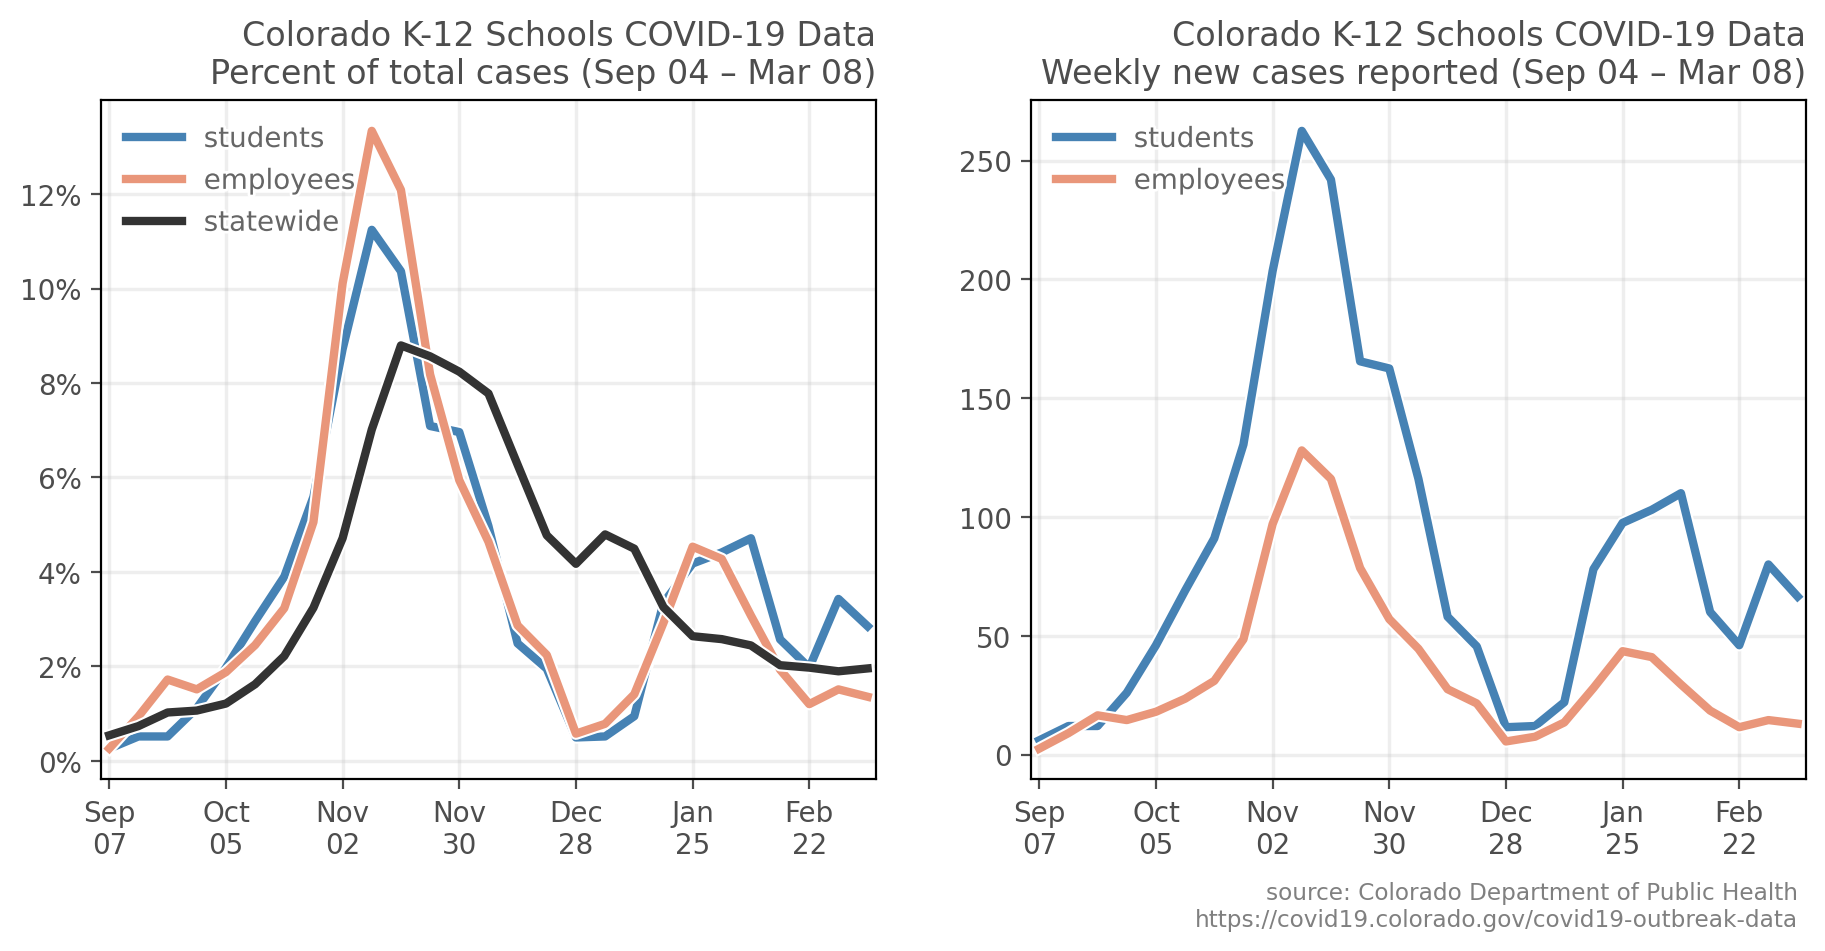

In [303]:
lw = 3
fig, ax = plt.subplots(1,2,figsize=(11,4.5),dpi=200)
wid = 2

labs_tx = ['students','employees','statewide']
cols = ['steelblue','darksalmon','.2']
for ci, col in enumerate(['new_cases_students','new_cases_employee','new_cases_state']):
    xvals_i = [date_dict[i] for i in co_dfg['date'].values]
    yvals_i = co_dfg[col].rolling(window=wid).mean().values
    ax[0].plot(xvals_i, yvals_i/np.nansum(yvals_i), label=labs_tx[ci], lw=lw, color=cols[ci],
            path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                          path_effects.Normal()])
    if ci < 2:
        yvals_i = co_dfg[col].rolling(window=wid).mean().values
        ax[1].plot(xvals_i, yvals_i, label=labs_tx[ci], lw=lw, color=cols[ci],
                path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                              path_effects.Normal()])



dates = sorted(co_dfg['date'].values)[1::4]
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))
tlabs = ['Percent of total cases '+\
              '(%s %s – %s %s)'%(month_dict[co_dfg['date'].min()[5:7]],
                                 co_dfg['date'].min()[8:],
                                 month_dict[co_dfg['date'].max()[5:7]],
                                 co_dfg['date'].max()[8:]),
        'Weekly new cases reported '+\
              '(%s %s – %s %s)'%(month_dict[co_dfg['date'].min()[5:7]],
                                 co_dfg['date'].min()[8:],
                                 month_dict[co_dfg['date'].max()[5:7]],
                                 co_dfg['date'].max()[8:]),]

for ai,a in enumerate(fig.axes):
    a.set_xticks([date_dict[i] for i in dates])
    a.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates])
    l = a.legend(loc=2, ncol=1, framealpha=0)
    for text in l.get_texts():
        text.set_color('.4')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w'),
                               path_effects.Normal()])

    a.tick_params(labelcolor='.3', color='.3')
    a.grid(linewidth=1.25,color='.75',alpha=0.25)
    a.set_title('Colorado K-12 Schools COVID-19 Data\n'+tlabs[ai],
                x=1,color='.3',ha='right')
    a.set_xlim(date_dict[co_dfg['date'].min()]+1,
               date_dict[co_dfg['date'].max()]+2)

ax[1].text(0.99,-0.15,'source: Colorado Department of Public Health\n'+\
        'https://covid19.colorado.gov/covid19-outbreak-data',
        color='.5',fontsize='small', va='top', ha='right', transform=ax[1].transAxes)

plt.savefig('../figs/pngs/colorado_k12_studentstaff.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/colorado_k12_studentstaff.pdf',bbox_inches='tight')
plt.show()

# Connecticut 

https://data.ct.gov/Health-and-Human-Services/COVID-19-Cases-in-CT-Schools-By-School-/u8jq-fxc2

In [322]:
url_xi = 'https://data.ct.gov/resource/u8jq-fxc2.json'
with urllib.request.urlopen(url_xi) as url_i:
    md_page_i = json.loads(url_i.read().decode())


ct_df = pd.read_csv('../data/COVID-19_Cases_in_CT_Schools__By_School_.csv')
ct_df['Date updated'] = pd.to_datetime(ct_df['Date updated']).astype(str).str[:10]

ct_df = ct_df.rename(columns={'Date updated':'date_updated','District':'district',
                              'School name':'name','School ID':'school_id',
                              'City':'city','School total':'total_cases',
                              'Report period':'report_period'})
ct_df['total_cases'] = ct_df['total_cases'].str.replace('<6','0')
ct_df['total_cases'] = ct_df['total_cases'].astype(float)

ct_df['date'] = ct_df['report_period'].str.split(' - ').str[0]
ct_df['date'] = pd.to_datetime(ct_df['date']).astype(str).str[:10]
ct_df = ct_df[['date', 'district', 'school_id', 'city', 'total_cases']].copy()
ct_df = ct_df.merge(DATE_DF[['date','week']],how='left',on='date')

In [373]:
# ct_dfg = ct_df.groupby(['district','date','week','city']).agg({'total_cases':'sum'}).reset_index()
# ct_dfg = ct_dfg.groupby('week').agg({'total_cases':'sum',
#                                     'date':'min'}).reset_index()

ct_statewide = pd.read_csv('https://data.ct.gov/resource/vvjf-9vkr.csv')
ct_statewide['date'] = ct_statewide['report_period_start_date'].str[:10]
ct_statewide = ct_statewide[['date',
       'number_of_staff_cases', 'number_of_student_cases']].copy()#,
#        'number_of_in_person_student_cases', 'number_of_hybrid_student_cases',
#        'number_of_remote_student_cases',
#        'number_of_unknown_learning_model_student_cases']].copy()

ct_statewide = ct_statewide.rename(columns={
                             'number_of_staff_cases':'new_cases_employee',
                             'number_of_student_cases':'new_cases_students'})
ct_dfg = ct_statewide.sort_values('date').reset_index().iloc[:,1:]
ct_dfg = ct_dfg.merge(DATE_DF[['date','week']],how='left',on='date')

ll_ct_g = ll.loc[ll['state']=='Connecticut'].groupby(['week']).agg({'new_cases':'sum',
                                     'new_deaths':'sum', 'population':'mean'}).reset_index()
ll_ct_g = ll_ct_g.rename(columns={'new_cases':'new_cases_state',
                                  'new_deaths':'new_deaths_state',
                                  'population':'population_state'})
ct_dfg = ct_dfg.merge(ll_ct_g, how='left', on='week')

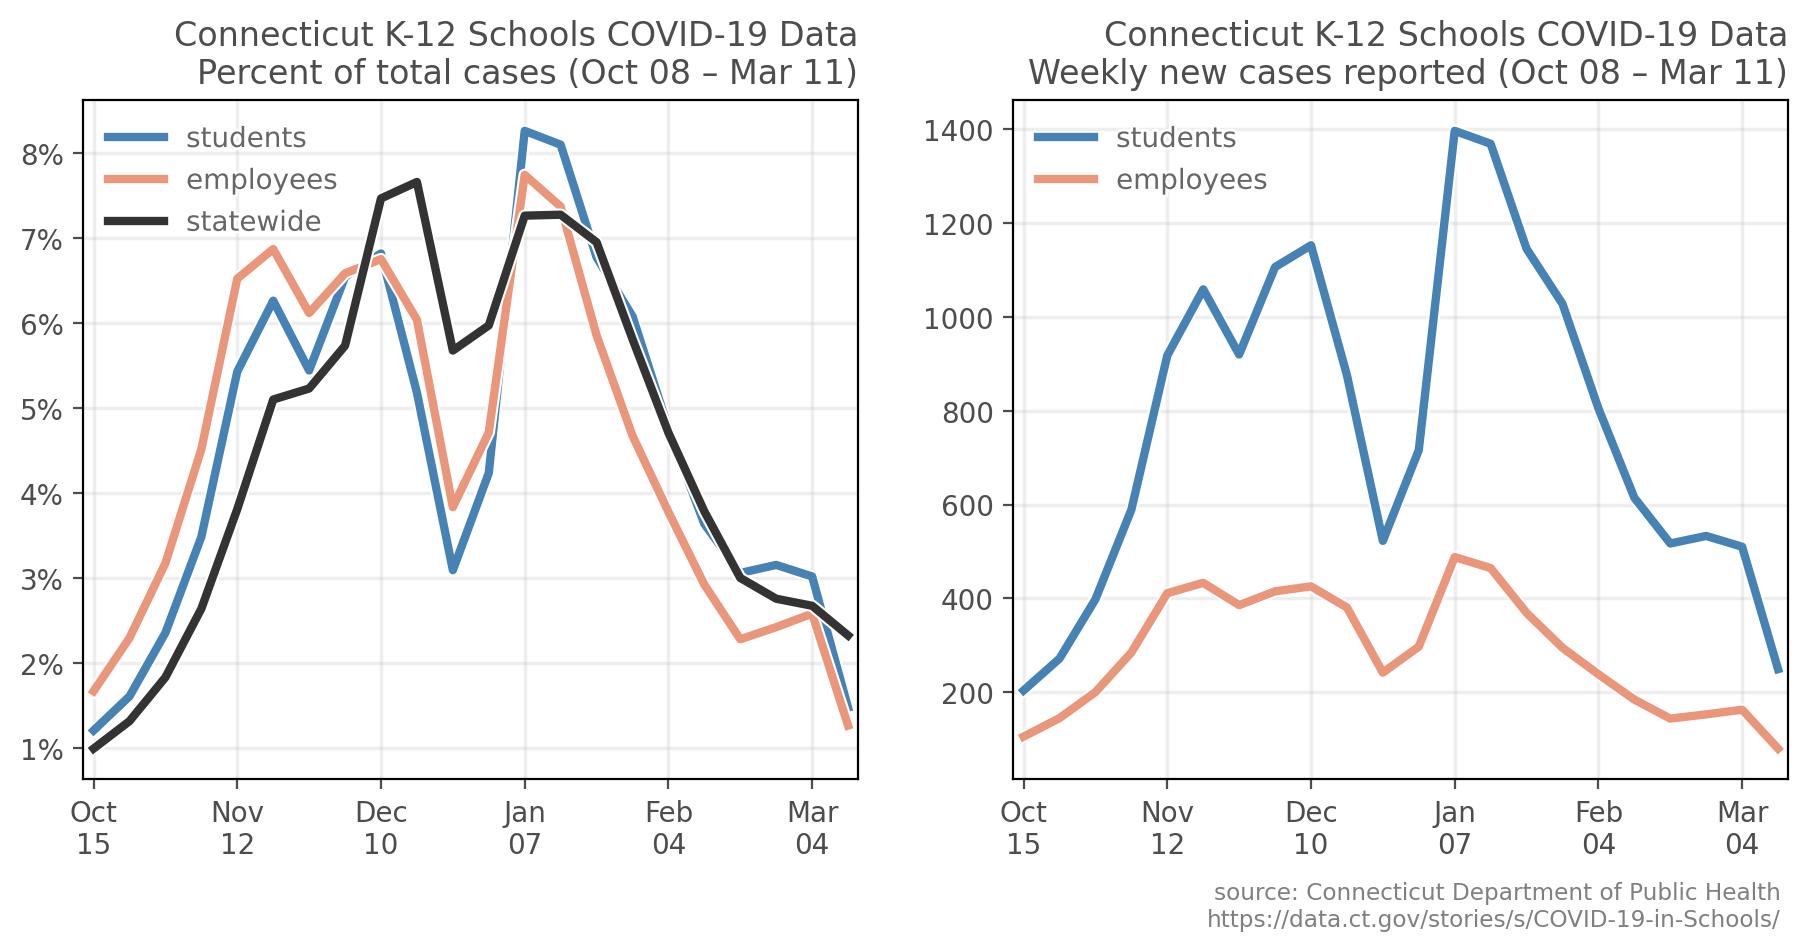

In [378]:
lw = 3
fig, ax = plt.subplots(1,2,figsize=(11,4.5),dpi=200)
wid = 2

labs_tx = ['students','employees','statewide']
cols = ['steelblue','darksalmon','.2']
for ci, col in enumerate(['new_cases_students','new_cases_employee','new_cases_state']):
    xvals_i = [date_dict[i] for i in ct_dfg['date'].values]
    yvals_i = ct_dfg[col].rolling(window=wid).mean().values
    ax[0].plot(xvals_i, yvals_i/np.nansum(yvals_i), label=labs_tx[ci], lw=lw, color=cols[ci],
            path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                          path_effects.Normal()])
    if ci < 2:
        yvals_i = ct_dfg[col].rolling(window=wid).mean().values
        ax[1].plot(xvals_i, yvals_i, label=labs_tx[ci], lw=lw, color=cols[ci],
                path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                              path_effects.Normal()])



dates = sorted(ct_dfg['date'].values)[1::4]
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))
tlabs = ['Percent of total cases '+\
              '(%s %s – %s %s)'%(month_dict[ct_dfg['date'].min()[5:7]],
                                 ct_dfg['date'].min()[8:],
                                 month_dict[ct_dfg['date'].max()[5:7]],
                                 ct_dfg['date'].max()[8:]),
        'Weekly new cases reported '+\
              '(%s %s – %s %s)'%(month_dict[ct_dfg['date'].min()[5:7]],
                                 ct_dfg['date'].min()[8:],
                                 month_dict[ct_dfg['date'].max()[5:7]],
                                 ct_dfg['date'].max()[8:]),]

for ai,a in enumerate(fig.axes):
    a.set_xticks([date_dict[i] for i in dates])
    a.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates])
    l = a.legend(loc=2, ncol=1, framealpha=0)
    for text in l.get_texts():
        text.set_color('.4')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w'),
                               path_effects.Normal()])

    a.tick_params(labelcolor='.3', color='.3')
    a.grid(linewidth=1.25,color='.75',alpha=0.25)
    a.set_title('Connecticut K-12 Schools COVID-19 Data\n'+tlabs[ai],
                x=1,color='.3',ha='right')
    a.set_xlim(date_dict[ct_dfg['date'].min()]+5,
               date_dict[ct_dfg['date'].max()]+2)

ax[1].text(0.99,-0.15,'source: Connecticut Department of Public Health\n'+\
        'https://data.ct.gov/stories/s/COVID-19-in-Schools/',
        color='.5',fontsize='small', va='top', ha='right', transform=ax[1].transAxes)

plt.savefig('../figs/pngs/connecticut_k12_studentstaff.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/connecticut_k12_studentstaff.pdf',bbox_inches='tight')
plt.show()

# Delaware 

https://myhealthycommunity.dhss.delaware.gov/locations/state/in-person-contagious/district-school-cases/range/2021-01-16/2021-01-22
https://myhealthycommunity.dhss.delaware.gov/locations/state/in-person-contagious/setting-school-cases

https://myhealthycommunity.dhss.delaware.gov/locations/state/covid_venue_reports/2021-01-24/2021-01-30

In [263]:
de_data = client.open("COVID-data_Delaware")
de_df = de_data.worksheet('schools')
de_df = pd.DataFrame(de_df.get_all_records(default_blank=np.nan))

de_df['num_students'] = de_df['num_students'].astype(float)
de_df['new_cases_students'] = de_df['new_cases_students'].astype(float)
de_df['new_cases_employee'] = de_df['new_cases_employee'].astype(float)

de_df['total_cases_employee'] = de_df['total_cases_employee'].astype(float)
de_df['total_cases_students'] = de_df['total_cases_students'].astype(float)



In [264]:
try:
    new_date0 = DATERANGE[date_dict[de_df['date'].max()]+7]
    new_date1 = DATERANGE[date_dict[de_df['date'].max()]+7+6]
    ds = new_date0,new_date1

    url_i = "https://myhealthycommunity.dhss.delaware.gov/locations/state/in-person-contagious/district-school-cases/range/%s/%s"%(ds[0],ds[1])
    dat_i0 = pd.read_html(url_i)[0]
    dat_i1 = pd.read_html(url_i)[1]
    dat_i0 = dat_i0.loc[dat_i0['District / Setting'].str.contains('School')].copy()
    dat_i1 = dat_i1.loc[dat_i1['District / Setting'].str.contains('School')].copy()
    dat_i0.columns = ['name','num_students','new_cases_students','total_cases_students']
    dat_i1.columns = ['name','new_cases_employee','total_cases_employee']

    dat_i = dat_i0.merge(dat_i1, how='left', on='name').reset_index().iloc[:,1:]
    dat_i['date'] = ds[0]
    de_df = pd.concat([de_df, dat_i])
    de_df = de_df.sort_values(['name','date']).reset_index().iloc[:,1:]
    de_df = de_df[['date', 'name', 'num_students',
               'new_cases_students', 'new_cases_employee',
               'total_cases_students', 'total_cases_employee']].copy()

except:
    pass

In [266]:
de_df.to_csv('../data/delaware_schools.csv',index=False)

# District of Columbia

https://coronavirus.dc.gov/page/outbreak-data

# Florida
http://ww11.doh.state.fl.us/comm/_partners/covid19_report_archive/school-reports/schools_latest.pdf


# Georgia

https://dph.georgia.gov/school-aged-covid-19-surveillance-data

# Hawaii



# Idaho

https://coronavirus.idaho.gov/resources-for-schools/

https://coronavirus.idaho.gov/wp-content/uploads/2021/03/School-Report-3.1.21-Fixed.pdf

https://services7.arcgis.com/ugRfT6qLoOKPTf05/arcgis/rest/services/Idaho_School_Districts_View_Layer/FeatureServer/0/query?f=json&where=status%20%3D%20%27IN%20PERSON%27&returnGeometry=true&spatialRel=esriSpatialRelIntersects&maxAllowableOffset=2445&geometry=%7B%22xmin%22%3A-13775786.985668924%2C%22ymin%22%3A5009377.085700948%2C%22xmax%22%3A-12523442.714244926%2C%22ymax%22%3A6261721.357124943%2C%22spatialReference%22%3A%7B%22wkid%22%3A102100%7D%7D&geometryType=esriGeometryEnvelope&inSR=102100&outFields=*&outSR=102100&resultType=tile


https://services7.arcgis.com/ugRfT6qLoOKPTf05/arcgis/rest/services/Idaho_School_Districts_View_Layer/FeatureServer/0/query?f=json&where=status%20%3D%20%27HYBRID%27&returnGeometry=true&spatialRel=esriSpatialRelIntersects&maxAllowableOffset=2445&geometry=%7B%22xmin%22%3A-13775786.985668924%2C%22ymin%22%3A5009377.085700948%2C%22xmax%22%3A-12523442.714244926%2C%22ymax%22%3A6261721.357124943%2C%22spatialReference%22%3A%7B%22wkid%22%3A102100%7D%7D&geometryType=esriGeometryEnvelope&inSR=102100&outFields=*&outSR=102100&resultType=tile



# Illinois

http://web.archive.org/web/*/https://www.dph.illinois.gov/covid19/location-exposure?regionID=0

https://idph.illinois.gov/DPHPublicInformation/api/covidct/GetCOVIDSchoolExposures

https://idph.illinois.gov/DPHPublicInformation/api/COVID/GetSchoolOutbreaks

https://isp.maps.arcgis.com/apps/opsdashboard/index.html#/fceeacb37da04de4b237ed941dd7d5c4

# Indiana
Not available at this time		Indiana COVID-19 Data Report	Use "School" tab to see the data that is updated every Monday and is broken down by student, teacher, and staff.

https://www.coronavirus.in.gov/map/covid-19-indiana-school-report.json




In [383]:
url_xi = 'https://www.coronavirus.in.gov/map/covid-19-indiana-school-report.json'

In [390]:
with urllib.request.urlopen(url_xi) as url_i:
    in_page_i = json.loads(url_i.read().decode())
print(in_page_i.keys())

dict_keys(['daily_school_cases', 'aggregate_cases', 'school_demographics', 'school_listing', 'report_date', 'updated_date'])


In [412]:
in_df = pd.DataFrame(in_page_i['daily_school_cases'])
in_df['new_cases_employee'] = in_df[['staff_new_cases','teacher_new_cases']].sum(axis=1)+in_df[['staff_existing_cases','teacher_existing_cases']].sum(axis=1)
in_df['new_cases_students'] = in_df['student_new_cases']+in_df['student_existing_cases']
in_df = in_df[['date','new_cases_employee','new_cases_students']].copy()


# in_dfg = ct_statewide.sort_values('date').reset_index().iloc[:,1:]
# ct_dfg = ct_dfg.merge(DATE_DF[['date','week']],how='left',on='date')

ll_in_g = ll.loc[ll['state']=='Indiana'].copy()
ll_in_g = ll_in_g.rename(columns={'new_cases':'new_cases_state',
                                  'new_deaths':'new_deaths_state',
                                  'population':'population_state'})
in_dfg = in_df.merge(ll_in_g, how='left', on='date')

In [413]:
in_dfg = in_dfg.groupby('week').agg({'new_cases_employee':'sum',
                            'new_cases_students':'sum',
                            'new_cases_state':'sum',
                            'new_deaths_state':'sum',
                            'date':'min',
                            'population_state':'mean'}).reset_index()

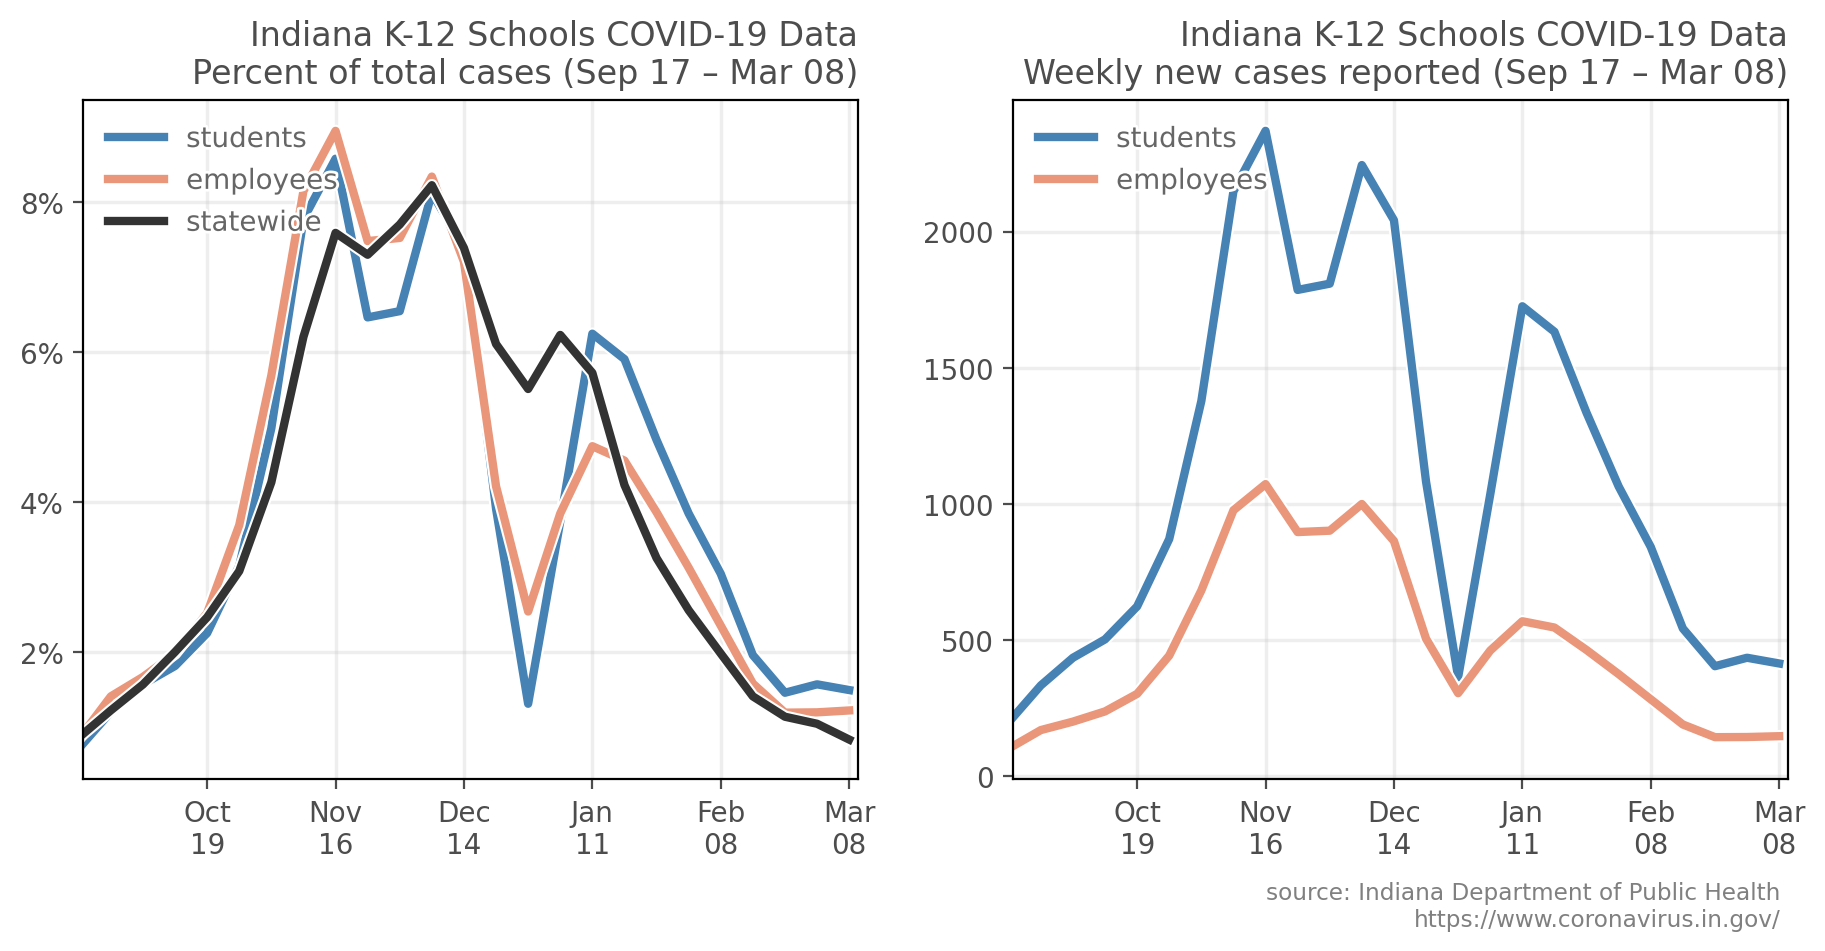

In [417]:
lw = 3
fig, ax = plt.subplots(1,2,figsize=(11,4.5),dpi=200)
wid = 2

labs_tx = ['students','employees','statewide']
cols = ['steelblue','darksalmon','.2']
for ci, col in enumerate(['new_cases_students','new_cases_employee','new_cases_state']):
    xvals_i = [date_dict[i] for i in in_dfg['date'].values]
    yvals_i = in_dfg[col].rolling(window=wid).mean().values
    ax[0].plot(xvals_i, yvals_i/np.nansum(yvals_i), label=labs_tx[ci], lw=lw, color=cols[ci],
            path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                          path_effects.Normal()])
    if ci < 2:
        yvals_i = in_dfg[col].rolling(window=wid).mean().values
        ax[1].plot(xvals_i, yvals_i, label=labs_tx[ci], lw=lw, color=cols[ci],
                path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                              path_effects.Normal()])



dates = sorted(in_dfg['date'].values)[1::4]
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))
tlabs = ['Percent of total cases '+\
              '(%s %s – %s %s)'%(month_dict[in_dfg['date'].min()[5:7]],
                                 in_dfg['date'].min()[8:],
                                 month_dict[in_dfg['date'].max()[5:7]],
                                 in_dfg['date'].max()[8:]),
        'Weekly new cases reported '+\
              '(%s %s – %s %s)'%(month_dict[in_dfg['date'].min()[5:7]],
                                 in_dfg['date'].min()[8:],
                                 month_dict[in_dfg['date'].max()[5:7]],
                                 in_dfg['date'].max()[8:]),]

for ai,a in enumerate(fig.axes):
    a.set_xticks([date_dict[i] for i in dates])
    a.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates])
    l = a.legend(loc=2, ncol=1, framealpha=0)
    for text in l.get_texts():
        text.set_color('.4')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w'),
                               path_effects.Normal()])

    a.tick_params(labelcolor='.3', color='.3')
    a.grid(linewidth=1.25,color='.75',alpha=0.25)
    a.set_title('Indiana K-12 Schools COVID-19 Data\n'+tlabs[ai],
                x=1,color='.3',ha='right')
    a.set_xlim(date_dict[in_dfg['date'].min()]+5,
               date_dict[in_dfg['date'].max()]+2)

ax[1].text(0.99,-0.15,'source: Indiana Department of Public Health\n'+\
        'https://www.coronavirus.in.gov/',
        color='.5',fontsize='small', va='top', ha='right', transform=ax[1].transAxes)

# plt.savefig('../figs/pngs/indiana_k12_studentstaff.png',dpi=425,bbox_inches='tight')
# plt.savefig('../figs/pdfs/indiana_k12_studentstaff.pdf',bbox_inches='tight')
plt.show()

# Iowa
Summary of Schools Providing Primarily Continuous/Remote Learning		Not available at this time	The state has a dashboard that shows the past 14 day average positivity rates by county that school districts can use.

https://educateiowa.gov/covid-19/requests-move-remote-learning-school-building-or-district


# Kansas
Not available at this time		Not available at this time

# Kentucky
Not available at this time		K-12 School COVID-19 Self-Reported Data

https://public.tableau.com/profile/chfs.dph#!/vizhome/COVID19SchoolSelfReportngData/SchoolSelfReportCovid19DB

# Louisiana
Learning Environment and Connectivity Tool		COVID-19 Outbreaks - K-12 Schools Reporting	The Louisiana Department of Health's dashboard breaks cases down by parish.

https://ldh.la.gov/assets/oph/Coronavirus/resources/k-12/reporting/K-12ReportbyParish-02282021.pdf

https://datastudio.google.com/u/0/reporting/57592098-3276-452a-9872-456384c0acdc/page/2oidB?s=jF2UNzlqNKM

In [7]:
la_data = client.open("COVID-data_Louisiana")
la_df = la_data.worksheet('schools')
la_df = pd.DataFrame(la_df.get_all_records(default_blank=np.nan))

la_df['new_cases_students'] = la_df['new_cases_students'].astype(float)
la_df['new_cases_employee'] = la_df['new_cases_employee'].astype(float)

In [8]:
la_dfg = la_df.groupby('date').agg({'new_cases_employee':'sum',
                                    'new_cases_students':'sum'}).reset_index()
la_dfg = la_dfg.merge(DATE_DF[['date','week']], how='left', on='date')
ll_la_g = ll.loc[ll['state']=='Louisiana'].groupby(['week']).agg({'new_cases':'sum',
                                     'new_deaths':'sum', 'population':'mean'}).reset_index()
ll_la_g = ll_la_g.rename(columns={'new_cases':'new_cases_state',
                                  'new_deaths':'new_deaths_state',
                                  'population':'population_state'})
la_dfg = la_dfg.merge(ll_la_g, how='left', on='week')

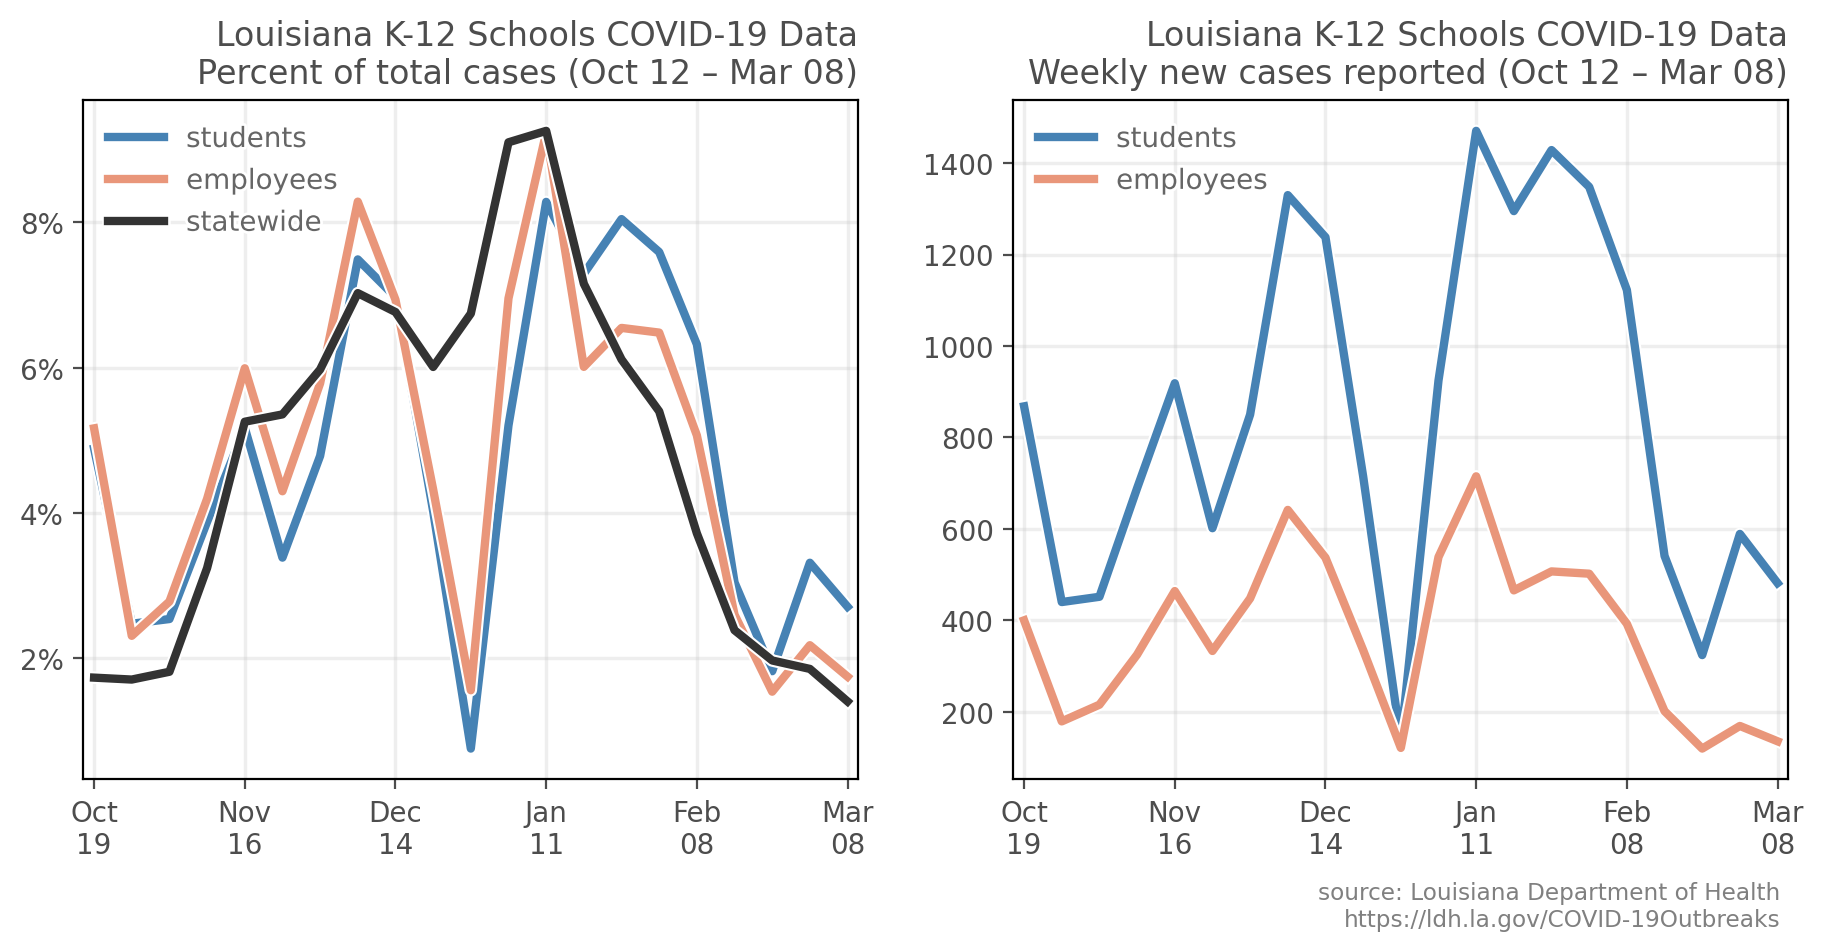

In [12]:
lw = 3
fig, ax = plt.subplots(1,2,figsize=(11,4.5),dpi=200)

labs_tx = ['students','employees','statewide']
cols = ['steelblue','darksalmon','.2']
for ci, col in enumerate(['new_cases_students','new_cases_employee','new_cases_state']):
    xvals_i = [date_dict[i] for i in la_dfg['date'].values]
    yvals_i = la_dfg[col].rolling(window=2).mean().values
    ax[0].plot(xvals_i, yvals_i/np.nansum(yvals_i), label=labs_tx[ci], lw=lw, color=cols[ci],
            path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                          path_effects.Normal()])
    if ci < 2:
        yvals_i = la_dfg[col].rolling(window=2).mean().values
        ax[1].plot(xvals_i, yvals_i, label=labs_tx[ci], lw=lw, color=cols[ci],
                path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                              path_effects.Normal()])



dates = sorted(la_dfg['date'].values)[1::4]
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))
tlabs = ['Percent of total cases '+\
              '(%s %s – %s %s)'%(month_dict[la_dfg['date'].min()[5:7]],
                                 la_dfg['date'].min()[8:],
                                 month_dict[la_dfg['date'].max()[5:7]],
                                 la_dfg['date'].max()[8:]),
        'Weekly new cases reported '+\
              '(%s %s – %s %s)'%(month_dict[la_dfg['date'].min()[5:7]],
                                 la_dfg['date'].min()[8:],
                                 month_dict[la_dfg['date'].max()[5:7]],
                                 la_dfg['date'].max()[8:]),]

for ai,a in enumerate(fig.axes):
    a.set_xticks([date_dict[i] for i in dates])
    a.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates])
    l = a.legend(loc=2, ncol=1, framealpha=0)
    for text in l.get_texts():
        text.set_color('.4')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w'),
                               path_effects.Normal()])

    a.tick_params(labelcolor='.3', color='.3')
    a.grid(linewidth=1.25,color='.75',alpha=0.25)
    a.set_title('Louisiana K-12 Schools COVID-19 Data\n'+tlabs[ai],
                x=1,color='.3',ha='right')
    a.set_xlim(date_dict[la_dfg['date'].min()]+5,
                date_dict[la_dfg['date'].max()]+2)

ax[1].text(0.99,-0.15,'source: Louisiana Department of Health\n'+\
        'https://ldh.la.gov/COVID-19Outbreaks',
        color='.5',fontsize='small', va='top', ha='right', transform=ax[1].transAxes)

# plt.savefig('../figs/pngs/louisiana_k12_studentstaff.png',dpi=425,bbox_inches='tight')
# plt.savefig('../figs/pdfs/louisiana_k12_studentstaff.pdf',bbox_inches='tight')
plt.show()

# Maine
Not available at this time		COVID-19 Cases in Maine Pre-K-12 Schools Over the Last 30 days	Updated on Thursdays at 4pm.


# Maryland
Positive COVID-19 Related Status of Instructional Models		MD COVID-19 SchoolOutbreak

https://coronavirus.maryland.gov/datasets/md-covid19-schooloutbreaks/data

http://www.marylandpublicschools.org/newsroom/_layouts/15/xlviewer.aspx?id=/newsroom/Documents/School-System-Instructional-Status-Form.xlsx

In [690]:
url_xi = 'https://opendata.arcgis.com/datasets/004454e8b70847f89b776b1caf94b30b_0.geojson'
with urllib.request.urlopen(url_xi) as url_i:
    md_page_i = json.loads(url_i.read().decode())

md_df = pd.DataFrame([x['properties'] for x in md_page_i['features']]).iloc[:,1:]
md_df['ReportDate'] = pd.to_datetime(md_df['ReportDate']).astype(str).str[:10]

md_df = md_df.rename(columns={'School':'name','CountyReport':'county',
                              'Number_of_Total_Cases':'new_cases','ReportDate':'date'})
md_df = md_df[['name','county','date','new_cases']].copy()
md_df = md_df.merge(DATE_DF[['date','week']],how='left',on='date')

In [696]:
# md_df.to_csv('../data/maryland_schools.csv',index=False)

# Massachusetts
Not available at this time	The state has a list of district reopening models at the beginning of the academic year available here: 🔗	Positive COVID-19 Cases in Schools

https://www.doe.mass.edu/covid19/positive-cases/

In [711]:
ma_data = client.open("COVID-data-Massachusetts")
ma_data = pd.DataFrame(ma_data.worksheet('k12_schools').get_all_records(default_blank=np.nan))
ma_data = ma_data[['date','school_id','name','new_cases_students',
                   'new_cases_employee','details']].copy()
ma_data['new_cases_students'] = ma_data['new_cases_students'].astype(float)
ma_data['new_cases_employee'] = ma_data['new_cases_employee'].astype(float)

In [712]:
ma_dfg = ma_data.groupby('date').agg({'new_cases_employee':'sum',
                                     'new_cases_students':'sum'}).reset_index()
ma_dfg = ma_dfg.merge(DATE_DF[['date','week']], how='left', on='date')
ll_ma_g = ll.loc[ll['state']=='Massachusetts'].groupby(['week']).agg({'new_cases':'sum',
                                         'new_deaths':'sum', 'population':'mean'}).reset_index()
ll_ma_g = ll_ma_g.rename(columns={'new_cases':'new_cases_state',
                                  'new_deaths':'new_deaths_state',
                                  'population':'population_state'})
ma_dfg = ma_dfg.merge(ll_ma_g, how='left', on='week')

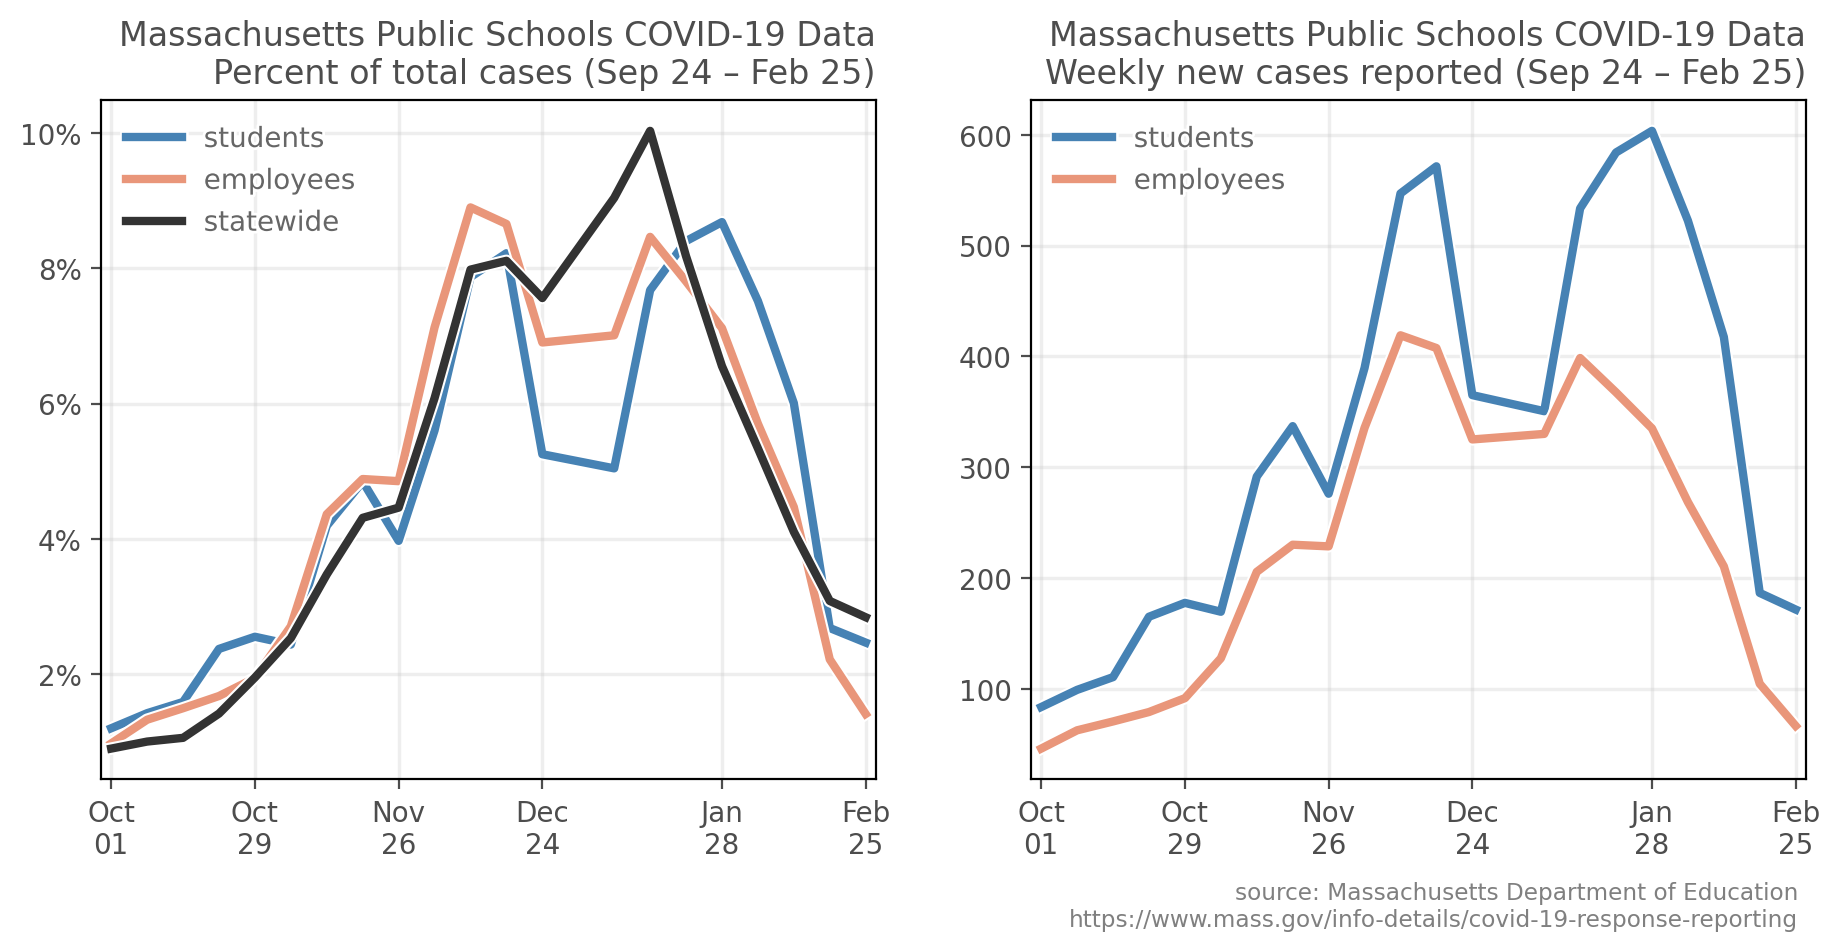

In [713]:
lw = 3
fig, ax = plt.subplots(1,2,figsize=(11,4.5),dpi=200)

labs_tx = ['students','employees','statewide']
cols = ['steelblue','darksalmon','.2']
for ci, col in enumerate(['new_cases_students','new_cases_employee','new_cases_state']):
    xvals_i = [date_dict[i] for i in ma_dfg['date'].values]
    yvals_i = ma_dfg[col].rolling(window=2).mean().values
    ax[0].plot(xvals_i, yvals_i/np.nansum(yvals_i), label=labs_tx[ci], lw=lw, color=cols[ci],
            path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                          path_effects.Normal()])
    if ci < 2:
        yvals_i = ma_dfg[col].rolling(window=2).mean().values
        ax[1].plot(xvals_i, yvals_i, label=labs_tx[ci], lw=lw, color=cols[ci],
                path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                              path_effects.Normal()])



dates = sorted(ma_dfg['date'].values)[1::4]
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))
tlabs = ['Percent of total cases '+\
              '(%s %s – %s %s)'%(month_dict[ma_dfg['date'].min()[5:7]],
                                 ma_dfg['date'].min()[8:],
                                 month_dict[ma_dfg['date'].max()[5:7]],
                                 ma_dfg['date'].max()[8:]),
        'Weekly new cases reported '+\
              '(%s %s – %s %s)'%(month_dict[ma_dfg['date'].min()[5:7]],
                                 ma_dfg['date'].min()[8:],
                                 month_dict[ma_dfg['date'].max()[5:7]],
                                 ma_dfg['date'].max()[8:]),]

for ai,a in enumerate(fig.axes):
    a.set_xticks([date_dict[i] for i in dates])
    a.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates])
    l = a.legend(loc=2, ncol=1, framealpha=0)
    for text in l.get_texts():
        text.set_color('.4')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w'),
                               path_effects.Normal()])

    a.tick_params(labelcolor='.3', color='.3')
    a.grid(linewidth=1.25,color='.75',alpha=0.25)
    a.set_title('Massachusetts Public Schools COVID-19 Data\n'+tlabs[ai],
                x=1,color='.3',ha='right')
    a.set_xlim(date_dict[ma_dfg['date'].min()]+5,
                date_dict[ma_dfg['date'].max()]+2)

ax[1].text(0.99,-0.15,'source: Massachusetts Department of Education\n'+\
        'https://www.mass.gov/info-details/covid-19-response-reporting',
        color='.5',fontsize='small', va='top', ha='right', transform=ax[1].transAxes)


# plt.savefig('../figs/pngs/massachusetts_k12_studentstaff.png',dpi=425,bbox_inches='tight')
# plt.savefig('../figs/pdfs/massachusetts_k12_studentstaff.pdf',bbox_inches='tight')
plt.show()

# Michigan
Extended COVID-19 Learning Plan Dashboard		School-Related Outbreak Reporting	This page is updated every Monday.

https://www.mischooldata.org/covid-dashboard/

https://www.michigan.gov/coronavirus/0,9753,7-406-98163_98173_102480---,00.html

In [667]:
url_m = 'https://www.michigan.gov/coronavirus/0,9753,7-406-98163_98173_102480---,00.html'
d = '2020-10-01'
ds = d.replace('-','')
url_i = 'http://web.archive.org/web/%s/'%(ds)+url_m


'http://web.archive.org/web/20201001/https://www.michigan.gov/coronavirus/0,9753,7-406-98163_98173_102480---,00.html'

In [677]:
# old_out = []
# visited_d = []
# for d in list(date_dict.keys())[240:241]:
# # for d in list(date_dict.keys())[240:440]:
#     stest = d.replace('-','')
#     try:
#         url_i = 'http://web.archive.org/web/%s/'%(ds)+url_m
#         url_i = urllib.request.urlopen(url_i).url
#         if url_i not in visited_d:
#             df_i = pd.read_html(url_i)[3]
#             df_i['date'] = d
#             visited_d.append(url_i)
#             print(d, url_i)
#             old_out.append(df_i)
#     except:
#         continue
        
new_out = []
visited_d = []
for d in list(date_dict.keys())[240:441]:
# for d in list(date_dict.keys())[240:440]:
    stest = d.replace('-','')
    try:
        url_i = 'http://web.archive.org/web/%s/'%(ds)+url_m
        url_i = urllib.request.urlopen(url_i).url
        if url_i not in visited_d:
            df_i = pd.read_html(url_i)[2]
            df_i['date'] = d
            visited_d.append(url_i)
            print(d, url_i)
            new_out.append(df_i)
    except:
        continue

2020-09-02 http://web.archive.org/web/20201001172633/https://www.michigan.gov/coronavirus/0,9753,7-406-98163_98173_102480---,00.html


# Minnesota
Safe Learning Model Data	This page links to a dashboard that compiles instructional model data self-reported from districts and charter schools.	COVID-19 Situation Update	School buildings reporting 5 or more cases are listed in the "Facilities with Cases & Exposures" and more detailed data can be found in the weekly reports.

https://www.health.state.mn.us/diseases/coronavirus/situation.html#ccf1

https://education.mn.gov/MDE/dse/health/covid19/slmd/

# Mississippi
Not available at this time		COVID-19 Cases and Outbreaks in K-12 Schools

https://www.msdh.ms.gov/msdhsite/_static/14,0,420,972.html

# Missouri
Statewide Patterns of Instruction		COVID-19 in School District Communities

https://dese.mo.gov/communications/coronavirus-covid-19-information

https://showmestrong.mo.gov/data/public-health/school-districts/


# Montana
Not available at this time		Coronavirus Disease 2019 (COVID-19)	The COVID-19 in Montana Schools report, which is updated every Wednesday, can be accessed from the Coronavirus Disease 2019 (COVID-19) dashboard.




# Nebraska
Not available at this time		Not available at this time		


# Nevada
Not available at this time		Not available at this time		


# New Hampshire
COVID-19 Schools Dashboard		COVID-19 Schools Dashboard

https://www.nh.gov/covid19/dashboard/schools.htm#dash



# New Jersey
Not available at this time		COVID-19 Information Hub	Use the Schools tab to see the NJ COVID-19 School-Related Outbreaks Dashboard

https://covid19.nj.gov/forms/datadashboard


# New Mexico
School Reentry Status	Scroll down to the button for "School Reentry Status	Rapid Response Covid-19 Watchlist	For school-related cases, search for "NMPED" in the search bar.

https://www.env.nm.gov/rapid-response-data/

https://webnew.ped.state.nm.us/reentry-district-and-school-guidance/

# New York
Not available at this time		COVID-19 Report Card

https://schoolcovidreportcard.health.ny.gov/#/home


# North Carolina
NC School Reopenings for 2020-21		NC School Reopenings for 2020-21


https://docs.google.com/spreadsheets/d/1We8gDpa4Do5NR83Nf8niGE_YxzLDf-KZh-tVWifStxE/edit#gid=0


# North Dakota
Not available at this time		K-12 School Dashboard

https://www.health.nd.gov/k-12-school-dashboard


# Ohio
Education Model for School Year 2021	Scroll down to see the map and the link that shows current instructional models.	COVID-19 Dashboard

http://education.ohio.gov/Topics/Reset-and-Restart

https://coronavirus.ohio.gov/wps/portal/gov/covid-19/dashboards/schools-and-children/schools


# Oklahoma
Not available at this time		Not available at this time




# Oregon
School Status page	Updated on a weekly basis, this Department of Education data includes both private and public school information.	COVID-19 Reporting	Updated weekly, this page provides data on cases associated with schools that offer in-person instruction.

https://www.oregon.gov/ode/students-and-family/healthsafety/Pages/COVID-19-Reporting.aspx

https://www.oregon.gov/ode/students-and-family/healthsafety/Pages/2020-21-School-Status.aspx


# Pennsylvania
Not available at this time		Not available at this time




# Rhode Island

https://docs.google.com/spreadsheets/d/1c2QrNMz8pIbYEKzMJL7Uh2dtThOJa2j1sSMwiDo5Gz4/edit#gid=594871904

# South Carolina
School District COVID-19 Current Operational Status Map		COVID-19 Cases Associated with Staff & Students

http://web.archive.org/web/20210201230327/https://ed.sc.gov/districts-schools/schools/district-and-school-closures/operational-status/
https://scdhec.gov/covid19/resources-community-covid-19/covid-19-cases-associated-staff-students


# South Dakota
Not available at this time		South Dakota COVID-19 Updates	Scroll to the "South Dakota K-12 Schools and Colleges, Universities, and Technical Schools" report, which is updated on Mondays.

https://web.archive.org/web/20210128224326/https://doh.sd.gov/documents/COVID19/School-College_COVID_cases.pdf

https://doh.sd.gov/documents/COVID19/School-College_COVID_cases.pdf

https://docs.google.com/spreadsheets/d/1IkHzXyU2J2CFvynczaRwvoaaxdron2EHY4vb-WgnhRQ/edit#gid=0

In [13]:
sd_data = client.open("COVID-data_SouthDakota")
sd_data = pd.DataFrame(sd_data.worksheet('schools').get_all_records(default_blank=np.nan))
sd_data['new_cases_students'] = sd_data['new_cases_students'].astype(float)
sd_data['new_cases_employee'] = sd_data['new_cases_employee'].astype(float)

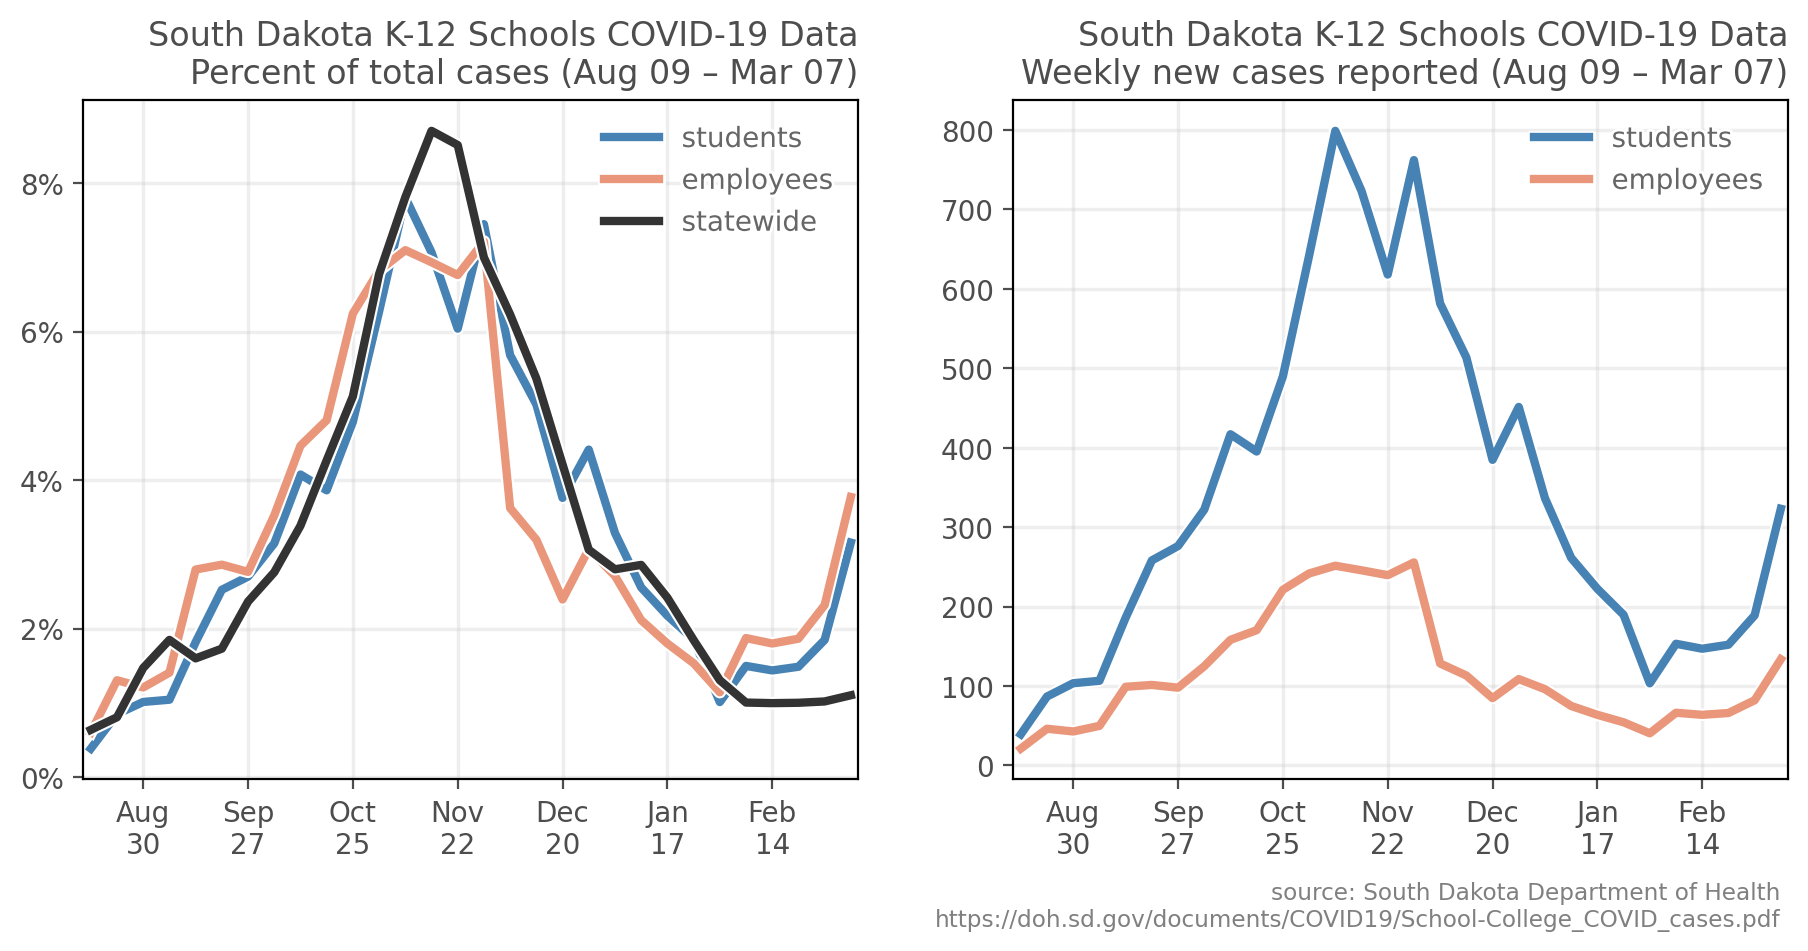

In [14]:
sd_dfg = sd_data.merge(DATE_DF[['date','week']], how='left', on='date')
ll_sd_g = ll.loc[ll['state']=='South Dakota'].groupby(['week']).agg({'new_cases':'sum',
                                         'new_deaths':'sum', 'population':'mean'}).reset_index()
ll_sd_g = ll_sd_g.rename(columns={'new_cases':'new_cases_state',
                                  'new_deaths':'new_deaths_state',
                                  'population':'population_state'})
sd_dfg = sd_dfg.merge(ll_sd_g, how='left', on='week')


import matplotlib.ticker as mtick
lw = 3
fig, ax = plt.subplots(1,2,figsize=(11,4.5),dpi=200)

labs_tx = ['students','employees','statewide']
cols = ['steelblue','darksalmon','.2']
for ci, col in enumerate(['new_cases_students','new_cases_employee','new_cases_state']):
    xvals_i = [date_dict[i] for i in sd_dfg['date'].values]
    yvals_i = sd_dfg[col].rolling(window=2).mean().values
    if ci < 2:
        yvals_i = sd_dfg['new_cases_k12'].rolling(window=2).mean().values *\
                (yvals_i/sd_dfg[['new_cases_employee',
                                 'new_cases_students']].sum(axis=1))
    ax[0].plot(xvals_i, yvals_i/np.nansum(yvals_i), label=labs_tx[ci], lw=lw, color=cols[ci],
            path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                          path_effects.Normal()])
    if ci < 2:
#         yvals_i = sd_dfg[col].values
        ax[1].plot(xvals_i, yvals_i, label=labs_tx[ci], lw=lw, color=cols[ci],
                path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                              path_effects.Normal()])


ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))
tlabs = ['Percent of total cases '+\
              '(%s %s – %s %s)'%(month_dict[sd_dfg['date'].min()[5:7]],
                                 sd_dfg['date'].min()[8:],
                                 month_dict[sd_dfg['date'].max()[5:7]],
                                 sd_dfg['date'].max()[8:]),
        'Weekly new cases reported '+\
              '(%s %s – %s %s)'%(month_dict[sd_dfg['date'].min()[5:7]],
                                 sd_dfg['date'].min()[8:],
                                 month_dict[sd_dfg['date'].max()[5:7]],
                                 sd_dfg['date'].max()[8:]),]
dates = sd_dfg['date'].values[3::4]
for ai,a in enumerate(fig.axes):
    a.set_xticks([date_dict[i] for i in dates])
    a.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates])
    l = a.legend(loc='upper right', ncol=1, framealpha=0)
    for text in l.get_texts():
        text.set_color('.4')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w'),
                               path_effects.Normal()])

    a.tick_params(labelcolor='.3', color='.3')
    a.grid(linewidth=1.25,color='.75',alpha=0.25)
    a.set_title('South Dakota K-12 Schools COVID-19 Data\n'+tlabs[ai], x=1,color='.3',ha='right')
    a.set_xlim(date_dict[sd_dfg['date'].min()]+5,
               date_dict[sd_dfg['date'].max()]+2)

ax[1].text(0.99,-0.15,'source: South Dakota Department of Health\n'+\
        'https://doh.sd.gov/documents/COVID19/School-College_COVID_cases.pdf',
        color='.5',fontsize='small', va='top', ha='right', transform=ax[1].transAxes)

plt.savefig('../figs/pngs/southdakota_k12_compare.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/southdakota_k12_compare.pdf',bbox_inches='tight')
plt.show()

# Tennessee
TDOE COVID-19 District Information	Districts are requested to submit COVID and instructional model data weekly.

https://districtinformation.tnedu.gov/

https://districtinformation.tnedu.gov/api/districts

http://web.archive.org/web/20201105231752/https://districtinformation.tnedu.gov/api/districts

In [17]:
tn_data = client.open("COVID-data_Tennessee")
tn_data = pd.DataFrame(tn_data.worksheet('schools').get_all_records(default_blank=np.nan))
tn_data['new_cases_students'] = tn_data['new_cases_students'].astype(float)
tn_data['new_cases_employee'] = tn_data['new_cases_employee'].astype(float)
tn_data['zip'] = tn_data['zip'].astype(str)

In [18]:
main_cols = ['id', 'name', 'address1', 'address2', 'city', 'zip',
             'phone', 'website', 'clp', 'latitude', 'longitude']
covidData_cols = ['studentCases','staffCases','lastWeekStudentCases','lastWeekStaffCases']

url_xi = 'https://districtinformation.tnedu.gov/api/districts'
with urllib.request.urlopen(url_xi) as url_i:
    tn_page_i = json.loads(url_i.read().decode())

tn_list_i = []
d = max([x['districtOperatingModel']['lastUpdatedDate'][:10] for x in tn_page_i])
for x in tn_page_i:
    main_dat_x = {i:x[i] for i in main_cols}
    main_dat_x['operatingModel'] = x['districtOperatingModel']['operatingModel']['name']
    main_dat_x['schoolOpeningDate'] = x['districtOperatingModel']['schoolOpeningDate']
    for ccc in covidData_cols:
        main_dat_x[ccc] = x['covidData'][ccc]

    tn_list_i.append(main_dat_x)

tn_df_i = pd.DataFrame(tn_list_i)
last_w_d = list(date_dict.keys())[date_dict[d]-7]

tn_df_i_prev = tn_df_i[['id', 'name', 'address1', 'address2', 'city', 'zip', 'phone', 'website',
                        'clp', 'latitude', 'longitude', 'operatingModel', 'schoolOpeningDate',
                        'lastWeekStudentCases', 'lastWeekStaffCases']].copy()
tn_df_i_curr = tn_df_i[['id', 'name', 'address1', 'address2', 'city', 'zip', 'phone', 'website',
                        'clp', 'latitude', 'longitude', 'operatingModel', 'schoolOpeningDate',
                        'studentCases', 'staffCases']].copy()

tn_df_i_curr['date'] = d
tn_df_i_curr = tn_df_i_curr.rename(columns={'studentCases':'new_cases_students',
                                            'staffCases':  'new_cases_employee'})

tn_df_i_prev['date'] = last_w_d
tn_df_i_prev = tn_df_i_prev.rename(columns={'lastWeekStudentCases':'new_cases_students',
                                            'lastWeekStaffCases':  'new_cases_employee'})

tn_df_x = pd.concat([tn_df_i_prev, tn_df_i_curr])

tn_df = tn_df_x.sort_values(['name','date']).reset_index().iloc[:,1:]
tn_df['schoolOpeningDate'] = tn_df['schoolOpeningDate'].str[:10]

tn_df = tn_df[['date', 'id', 'name', 'city', 'zip', 'schoolOpeningDate', 'operatingModel',
               'new_cases_students', 'new_cases_employee']].copy()

In [19]:
tn_df = pd.concat([tn_data,tn_df]).drop_duplicates().sort_values(['name','date']).reset_index().iloc[:,1:]

In [20]:
tn_df.to_csv('../data/tennessee_schools.csv',index=False)

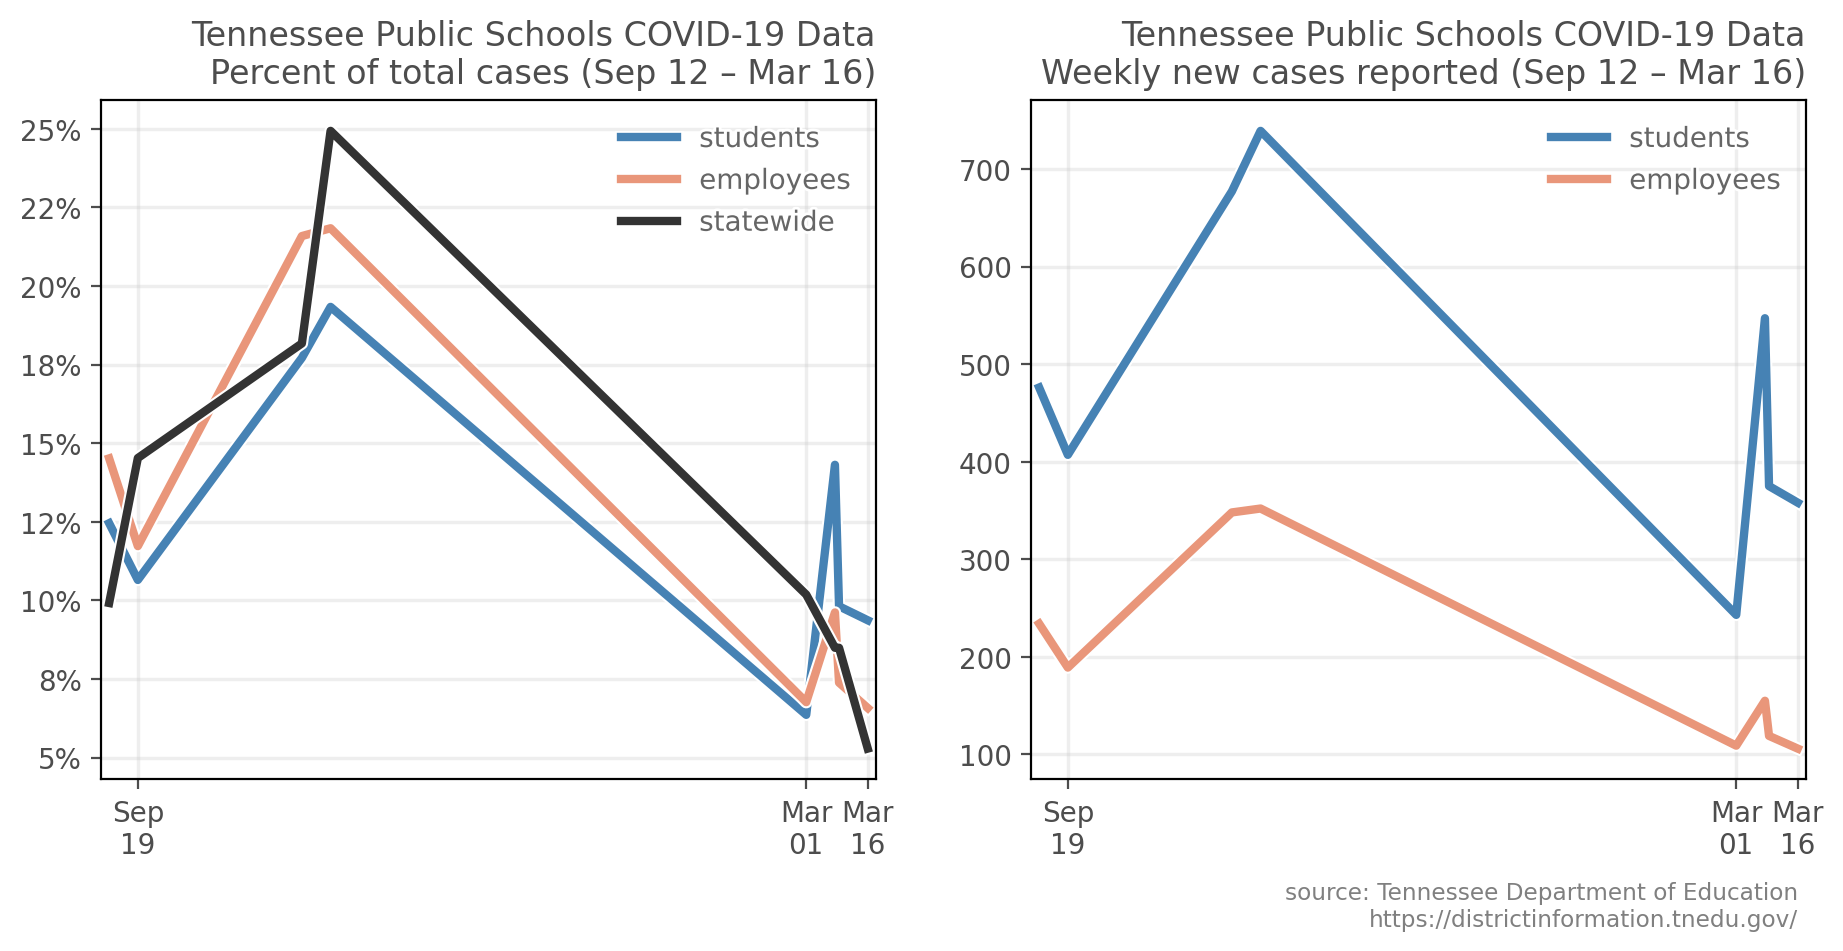

In [23]:
tn_dfg = tn_df.groupby(['date']).agg({'new_cases_students':'sum','new_cases_employee':'sum'}).reset_index()
tn_dfg = tn_dfg.merge(DATE_DF[['date','week']], how='left', on='date')
ll_tenn_g = ll.loc[ll['state']=='Tennessee'].groupby(['week']).agg({'new_cases':'sum',
                                         'new_deaths':'sum', 'population':'mean'}).reset_index()
ll_tenn_g = ll_tenn_g.rename(columns={'new_cases':'new_cases_state',
                                      'new_deaths':'new_deaths_state',
                                      'population':'population_state'})
tn_dfg = tn_dfg.merge(ll_tenn_g, how='left', on='week')


import matplotlib.ticker as mtick
lw = 3
fig, ax = plt.subplots(1,2,figsize=(11,4.5),dpi=200)

labs_tx = ['students','employees','statewide']
cols = ['steelblue','darksalmon','.2']
for ci, col in enumerate(['new_cases_students','new_cases_employee','new_cases_state']):
    xvals_i = [date_dict[i] for i in tn_dfg['date'].values]
    yvals_i = tn_dfg[col].values
    ax[0].plot(xvals_i, yvals_i/np.nansum(yvals_i), label=labs_tx[ci], lw=lw, color=cols[ci],
            path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                          path_effects.Normal()])
    if ci < 2:
        yvals_i = tn_dfg[col].values
        ax[1].plot(xvals_i, yvals_i, label=labs_tx[ci], lw=lw, color=cols[ci],
                path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                              path_effects.Normal()])


ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))
tlabs = ['Percent of total cases '+\
              '(%s %s – %s %s)'%(month_dict[tn_dfg['date'].min()[5:7]],
                                 tn_dfg['date'].min()[8:],
                                 month_dict[tn_dfg['date'].max()[5:7]],
                                 tn_dfg['date'].max()[8:]),
        'Weekly new cases reported '+\
              '(%s %s – %s %s)'%(month_dict[tn_dfg['date'].min()[5:7]],
                                 tn_dfg['date'].min()[8:],
                                 month_dict[tn_dfg['date'].max()[5:7]],
                                 tn_dfg['date'].max()[8:]),]
dates = tn_dfg['date'].values[1::3]
for ai,a in enumerate(fig.axes):
    a.set_xticks([date_dict[i] for i in dates])
    a.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates])
    l = a.legend(loc='upper right', ncol=1, framealpha=0)
    for text in l.get_texts():
        text.set_color('.4')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w'),
                               path_effects.Normal()])

    a.tick_params(labelcolor='.3', color='.3')
    a.grid(linewidth=1.25,color='.75',alpha=0.25)
    a.set_title('Tennessee Public Schools COVID-19 Data\n'+tlabs[ai], x=1,color='.3',ha='right')
    a.set_xlim(date_dict[tn_dfg['date'].min()]-2,
               date_dict[tn_dfg['date'].max()]+2)

ax[1].text(0.99,-0.15,'source: Tennessee Department of Education\n'+\
        'https://districtinformation.tnedu.gov/',
        color='.5',fontsize='small', va='top', ha='right', transform=ax[1].transAxes)

plt.savefig('../figs/pngs/tennessee_k12_compare.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/tennessee_k12_compare.pdf',bbox_inches='tight')
plt.show()

# Texas
Not available at this time	Texas requires school districts to provide daily, on-campus learning for any family who wants it in order to not lose state funding due to declines in enrollment.	Texas Public Schools COVID-19 Data	This report on public schools is updated on Fridays.

https://dshs.texas.gov/coronavirus/schools/texas-education-agency/

Abbreviations: EE= "Early Education",  ISD="Independent School District", CISD= "Consolidated Independent School District",INC= "Incorperated", LEA= "Local Education Authority" , NR= "No Enrollment Report Received"

\* indicates cell has been suppressed, a blank cell indicates no report has been received for a given district in the indicated time period,a 0 indicates that a report was received and no cases were reported for that group in the reported time period.

Data Notes: This set of reports provides an overview of COVID-19 cases in public schools in Texas.Cases in this report are defined as any staff member or student who participates in any on-campus activity that is test-confirmed COVID-19 of which a public school is notified.Updates for the previous Monday-Sunday are provided weekly by 5 pm CST on Thursdays. Because data is self-reported by schools, local or publicly available information may be more up to date.Private schools are not included in this report. To protect individual privacy, case counts will be suppressed for any school district that has fewer than 50 students enrolled on campus.Suppressed cases will be included in the statewide total. All data are provisional and subject to change.Corrections may lead to data being updated with more accurate or complete information.

Data Sources: Case data is self-reported to DSHS by individual public schools.

In [214]:
# https://docs.google.com/spreadsheets/d/128ksQTRqOgImXQ-_76wWtWjv0GnRH4lgENbRY3j24r0/edit#gid=901189319

In [24]:
tx_data = client.open("COVID-data_Texas")
tx_worksheets = [tt.title for tt in list(tx_data.worksheets()) if tt.title!='state']

In [25]:
state_df = pd.DataFrame(tx_data.worksheet('state').get_all_records(default_blank=np.nan))
state_df = state_df.merge(DATE_DF[['date','week']], how='left', on='date')

In [26]:
district_dfs = [pd.DataFrame(tx_data.worksheet(i).get_all_records(default_blank=np.nan))
                for i in tx_worksheets[0:9]]
districts_df = pd.concat(district_dfs)
districts_df['district_name'] = districts_df['district_name'].str.replace('\n',' ')
districts_df = districts_df.sort_values(['district_name','date']).reset_index().iloc[:,1:]

for x in ['new_cases_student_EE-3', 'new_cases_student_4-6',
          'new_cases_student_7-12', 'new_staff_cases', 'new_infected_oncampus',
          'new_infected_offcampus', 'new_infected_unknown',
          'total_cases_student_EE-3', 'total_cases_student_4-6',
          'total_cases_student_7-12', 'total_staff_cases',
          'total_infected_oncampus', 'total_infected_offcampus',
          'total_infected_unknown']:
    districts_df.loc[districts_df[x]=='.',x]=np.nan
    districts_df.loc[districts_df[x]=='*',x]=np.nan
    
for x in ['district_enrollment_firstweek','district_enrollment_firstweek_est']:
    districts_df.loc[districts_df[x]=='NR',x]=np.nan
    
districts_df['new_cases_student'] = districts_df[['new_cases_student_EE-3',
                                                  'new_cases_student_4-6',
                                                  'new_cases_student_7-12']].sum(axis=1)

In [27]:
campus_dfs = [pd.DataFrame(tx_data.worksheet(i).get_all_records(default_blank=np.nan))
              for i in tx_worksheets[9:]]
campus_df = pd.concat(campus_dfs)
campus_df['district_name'] = campus_df['district_name'].str.replace('\n',' ')
campus_df['campus_name'] = campus_df['campus_name'].str.replace('\n',' ')
campus_df = campus_df.loc[~campus_df['campus_name'].isna()].copy()

campus_df = campus_df.sort_values(['district_name','campus_name',
                                   'date']).reset_index().iloc[:,1:]

for x in ['new_cases_student', 'new_staff_cases', 'new_infected_oncampus',
         'new_infected_offcampus', 'new_infected_unknown', 'total_cases_student',
         'total_staff_cases', 'total_infected_oncampus',
         'total_infected_offcampus', 'total_infected_unknown']:
    campus_df.loc[campus_df[x]=='.',x]=np.nan
    campus_df.loc[campus_df[x]=='*',x]=np.nan
    
for x in ['district_enrollment_oct30','district_enrollment_oct30_est',
          'campus_enrollment_oct30', 'campus_enrollment_oct30_est']:
    campus_df.loc[campus_df[x]=='NR',x]=np.nan

campus_df_g = campus_df.groupby('date').agg(
                        {'district_enrollment_oct30':np.nansum,
                         'district_enrollment_oct30_est':np.nansum,
                         'campus_enrollment_oct30':np.nansum,
                         'campus_enrollment_oct30_est':np.nansum,
                         'new_cases_student':np.nansum, 'new_staff_cases':np.nansum,
                         'new_infected_oncampus':np.nansum, 'new_infected_offcampus':np.nansum,
                         'new_infected_unknown':np.nansum}).reset_index()

campus_df_g = campus_df.groupby('date').agg(
                        {'district_enrollment_oct30':np.nansum,
                         'district_enrollment_oct30_est':np.nansum,
                         'campus_enrollment_oct30':np.nansum,
                         'campus_enrollment_oct30_est':np.nansum,
                         'new_cases_student':np.nansum, 'new_staff_cases':np.nansum,
                         'new_infected_oncampus':np.nansum, 'new_infected_offcampus':np.nansum,
                         'new_infected_unknown':np.nansum}).reset_index()

In [28]:
district_df2 = campus_df.groupby(['district_name','date','district_lea']).agg(
    {'district_enrollment_oct30':np.nansum,
     'district_enrollment_oct30_est':np.nansum,
     'new_cases_student':np.nansum, 'new_staff_cases':np.nansum,
     'new_infected_oncampus':np.nansum, 'new_infected_offcampus':np.nansum,
     'new_infected_unknown':np.nansum}).reset_index()
district_df2 = district_df2.rename(columns={'district_enrollment_oct30':'district_enrollment',
                             'district_enrollment_oct30_est':'district_enrollment_est'})

district_df1 = districts_df[['district_name', 'date', 'district_lea', 
              'district_enrollment_firstweek', 'district_enrollment_firstweek_est',
              'new_cases_student', 'new_staff_cases', 'new_infected_oncampus',
       'new_infected_offcampus', 'new_infected_unknown']]

district_df1 = district_df1.rename(columns={'district_enrollment_firstweek':'district_enrollment',
                             'district_enrollment_firstweek_est':'district_enrollment_est'})

In [29]:
district_df = pd.concat([district_df1,district_df2]).sort_values(['district_name',
                                                  'date']).reset_index().iloc[:,1:]

In [30]:
districts_df_g = district_df.groupby('date').agg(
                        {'district_enrollment':np.nansum,
                         'district_enrollment_est':np.nansum,
                         'new_cases_student':np.nansum, 'new_staff_cases':np.nansum,
                         'new_infected_oncampus':np.nansum, 'new_infected_offcampus':np.nansum,
                         'new_infected_unknown':np.nansum}).reset_index()

districts_df_g = districts_df_g.merge(DATE_DF[['date','week']], how='left', on='date')

ll_texas_g = ll.loc[ll['state']=='Texas'].groupby(['week']).agg({'new_cases':'sum',
                                     'new_deaths':'sum', 'population':'mean'}).reset_index()
ll_texas_g = ll_texas_g.rename(columns={'new_cases':'new_cases_state',
                                        'new_deaths':'new_deaths_state',
                                        'population':'population_state'})

districts_df_g = districts_df_g.merge(ll_texas_g, how='left', on='week')
state_df_g = state_df.merge(ll_texas_g, how='left', on='week')

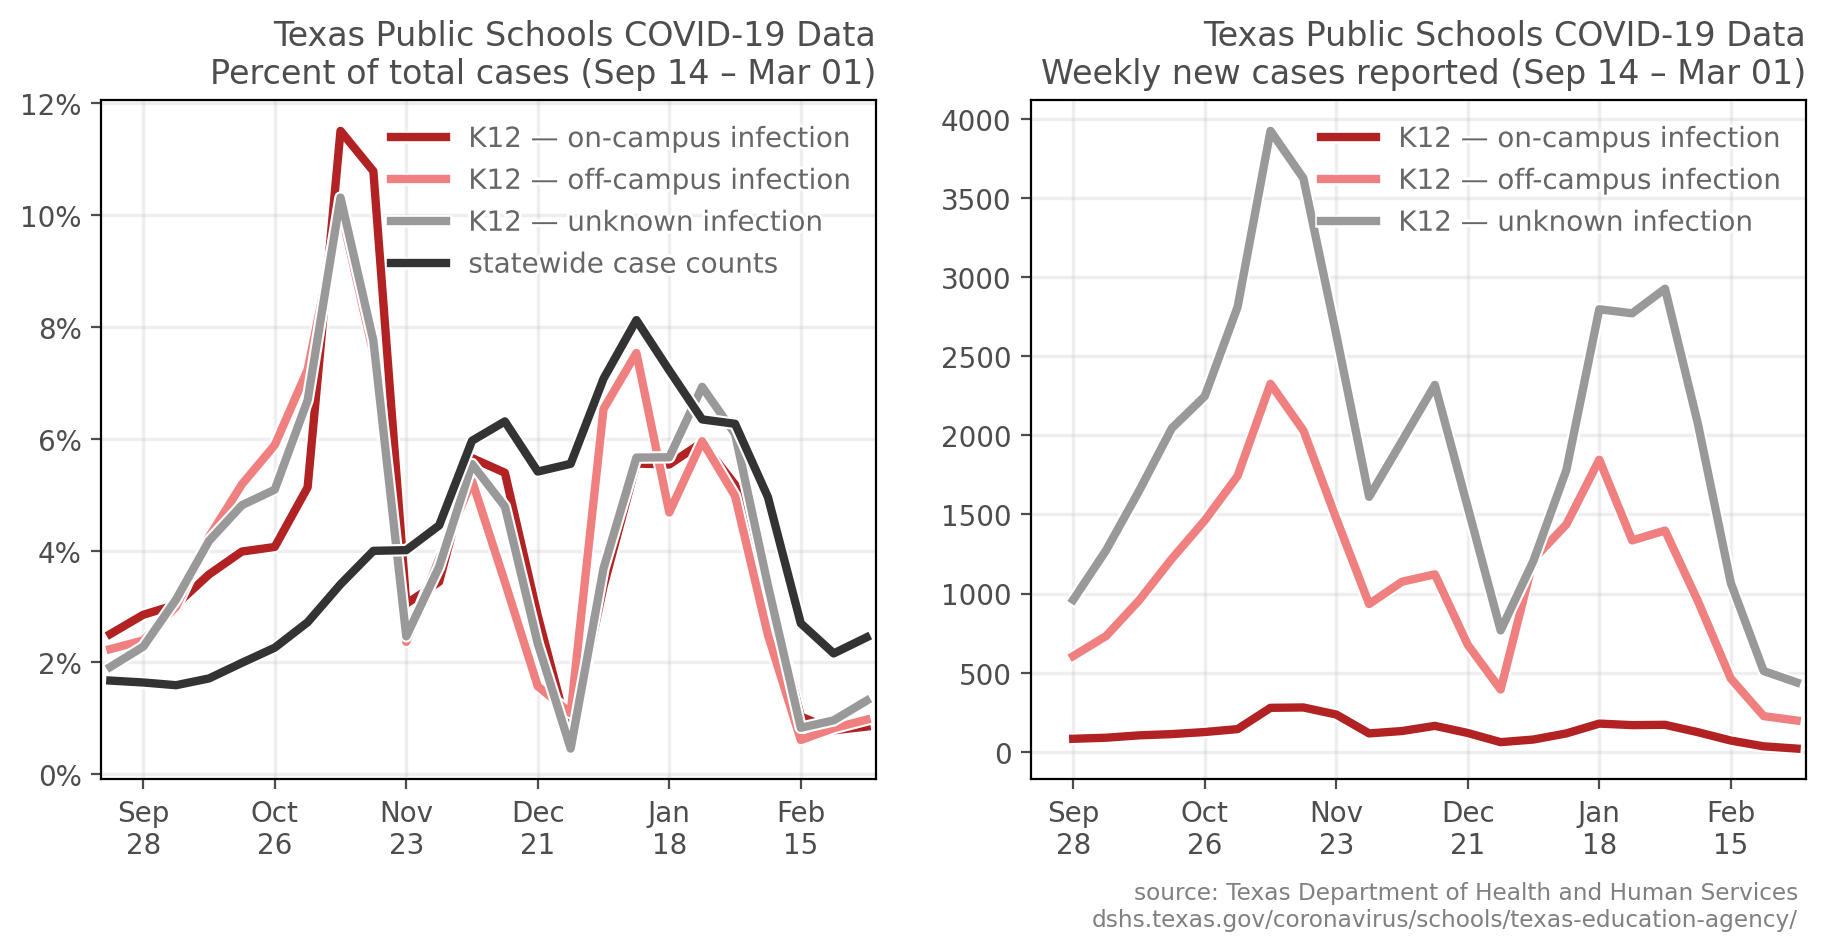

In [34]:
lw = 3
fig, ax = plt.subplots(1,2,figsize=(11,4.5),dpi=200)

labs_tx = ['K12 — on-campus infection','K12 — off-campus infection',
           'K12 — unknown infection','statewide case counts']
cols = ['firebrick','lightcoral','.6','.2']
for ci, col in enumerate(['new_infected_oncampus','new_infected_offcampus',
                          'new_infected_unknown','new_cases_state']):
    xvals_i = [date_dict[i] for i in districts_df_g['date'].values]
    yvals_i = districts_df_g[col].rolling(window=2).mean().values
    ax[0].plot(xvals_i, yvals_i/np.nansum(yvals_i), label=labs_tx[ci], lw=lw, color=cols[ci],
            path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                          path_effects.Normal()])
    if ci < 3:
        yvals_i = districts_df_g[col].rolling(window=3).mean().values
        ax[1].plot(xvals_i, yvals_i, label=labs_tx[ci], lw=lw, color=cols[ci],
                path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                              path_effects.Normal()])


ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))
tlabs = ['Percent of total cases '+\
              '(%s %s – %s %s)'%(month_dict[districts_df_g['date'].min()[5:7]],
                                 districts_df_g['date'].min()[8:],
                                 month_dict[districts_df_g['date'].max()[5:7]],
                                 districts_df_g['date'].max()[8:]),
        'Weekly new cases reported '+\
              '(%s %s – %s %s)'%(month_dict[districts_df_g['date'].min()[5:7]],
                                 districts_df_g['date'].min()[8:],
                                 month_dict[districts_df_g['date'].max()[5:7]],
                                 districts_df_g['date'].max()[8:]),]
dates = districts_df_g['date'].values[2::4]
for ai,a in enumerate(fig.axes):
    a.set_xticks([date_dict[i] for i in dates])
    a.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates])
    l = a.legend(loc='upper right', ncol=1, framealpha=0)
    for text in l.get_texts():
        text.set_color('.4')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w'),
                               path_effects.Normal()])

    a.tick_params(labelcolor='.3', color='.3')
    a.grid(linewidth=1.25,color='.75',alpha=0.25)
    a.set_title('Texas Public Schools COVID-19 Data\n'+tlabs[ai], x=1,color='.3',ha='right')
    a.set_xlim(date_dict[districts_df_g['date'].min()]+5,
                date_dict[districts_df_g['date'].max()]+2)

ax[1].text(0.99,-0.15,'source: Texas Department of Health and Human Services\n'+\
        'dshs.texas.gov/coronavirus/schools/texas-education-agency/',
        color='.5',fontsize='small', va='top', ha='right', transform=ax[1].transAxes)

plt.savefig('../figs/pngs/texas_k12_compare.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/texas_k12_compare.pdf',bbox_inches='tight')
plt.show()

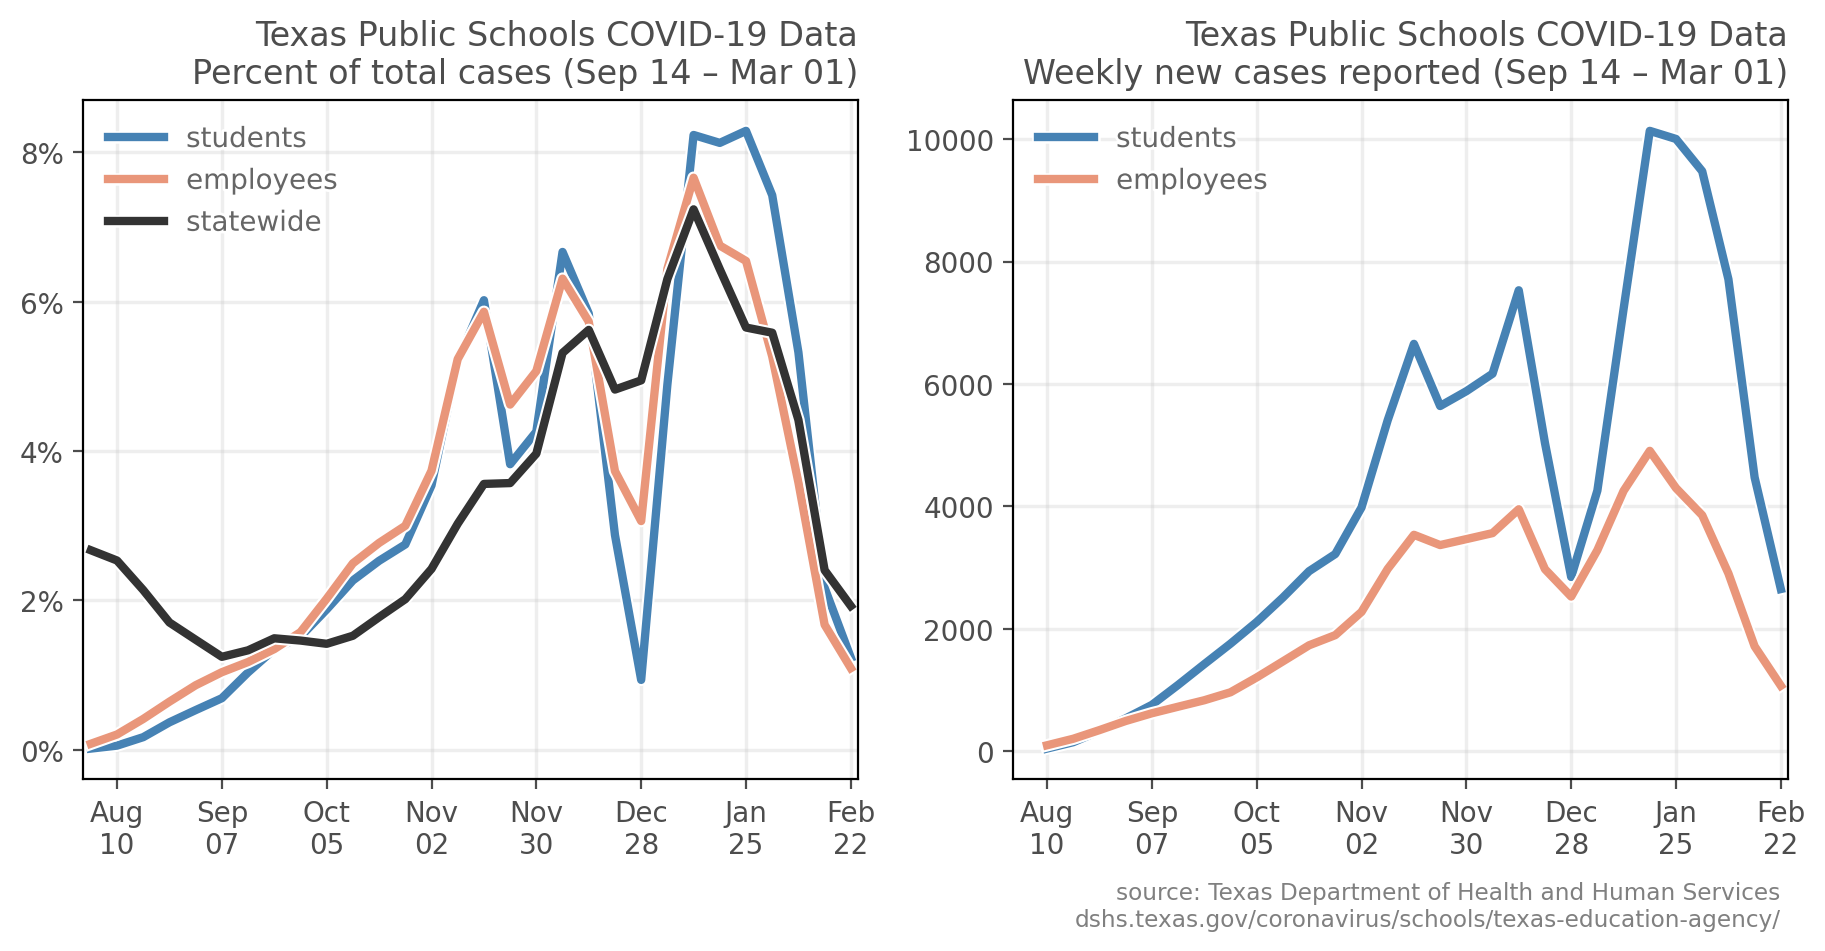

In [35]:
lw = 3
fig, ax = plt.subplots(1,2,figsize=(11,4.5),dpi=200)

labs_tx = ['students','employees','statewide']
cols = ['steelblue','darksalmon','.2']
for ci, col in enumerate(['new_cases_students','new_cases_employee','new_cases_state']):
    xvals_i = [date_dict[i] for i in state_df_g['date'].values]
    yvals_i = state_df_g[col].rolling(window=2).mean().values
    ax[0].plot(xvals_i, yvals_i/np.nansum(yvals_i), label=labs_tx[ci], lw=lw, color=cols[ci],
            path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                          path_effects.Normal()])
    if ci < 2:
        yvals_i = state_df_g[col].rolling(window=3).mean().values
        ax[1].plot(xvals_i, yvals_i, label=labs_tx[ci], lw=lw, color=cols[ci],
                path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                              path_effects.Normal()])



dates = state_df_g['date'].values[2::4]
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))
tlabs = ['Percent of total cases '+\
              '(%s %s – %s %s)'%(month_dict[districts_df_g['date'].min()[5:7]],
                                 districts_df_g['date'].min()[8:],
                                 month_dict[districts_df_g['date'].max()[5:7]],
                                 districts_df_g['date'].max()[8:]),
        'Weekly new cases reported '+\
              '(%s %s – %s %s)'%(month_dict[districts_df_g['date'].min()[5:7]],
                                 districts_df_g['date'].min()[8:],
                                 month_dict[districts_df_g['date'].max()[5:7]],
                                 districts_df_g['date'].max()[8:]),]

for ai,a in enumerate(fig.axes):
    a.set_xticks([date_dict[i] for i in dates])
    a.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates])
    l = a.legend(loc=2, ncol=1, framealpha=0)
    for text in l.get_texts():
        text.set_color('.4')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w'),
                               path_effects.Normal()])

    a.tick_params(labelcolor='.3', color='.3')
    a.grid(linewidth=1.25,color='.75',alpha=0.25)
    a.set_title('Texas Public Schools COVID-19 Data\n'+tlabs[ai], x=1,color='.3',ha='right')
    a.set_xlim(date_dict[state_df_g['date'].min()]+5,
                date_dict[state_df_g['date'].max()]+2)

ax[1].text(0.99,-0.15,'source: Texas Department of Health and Human Services\n'+\
        'dshs.texas.gov/coronavirus/schools/texas-education-agency/',
        color='.5',fontsize='small', va='top', ha='right', transform=ax[1].transAxes)


plt.savefig('../figs/pngs/texas_k12_studentstaff.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/texas_k12_studentstaff.pdf',bbox_inches='tight')
plt.show()

# Utah
Not available at this time		Case Counts	Use the schools tab to see the School-Associated Cases by School District report.	

https://coronavirus-dashboard.utah.gov/#schools

https://coronavirus-dashboard.utah.gov/

http://web.archive.org/web/2020*/https://coronavirus-dashboard.utah.gov/Utah_COVID19_data.zip

# Vermont
Not available at this time		PreK-12 Schools	Click on the "COVID-19 Cases in School While Infectious" link which is updated Tuesdays and Fridays.

https://www.healthvermont.gov/covid-19/your-community/prek-12-schools

http://web.archive.org/web/*/https://www.healthvermont.gov/sites/default/files/documents/pdf/COVID19-Transmission-Schools.pdf


# Virginia
State Snapshot: Virginia School Operational Status		COVID-19 Outbreaks by Selected Exposure Settings	This report is updated on Fridays.

https://www.doe.virginia.gov/support/health_medical/office/reopen-status.shtml

https://www.vdh.virginia.gov/coronavirus/covid-19-outbreaks-in-virginia-colleges-and-universities/




# Washington
School Reopening Data		Not available at this time

https://www.k12.wa.us/about-ospi/press-releases/novel-coronavirus-covid-19-guidance-resources/school-reopening-data

In [741]:
url_wa = 'https://data.wa.gov/resource/9i5d-c2m8.json'
with urllib.request.urlopen(url_wa) as url_i:
    wa_page_i = json.loads(url_i.read().decode())

wa_df = pd.DataFrame(wa_page_i)
wa_df

,week,districtname,districtcode,districtorganizationid,status,model_elementary,model_middle,model_high,gradelevels_remote_phasein,studentgroups_remote_phasein,...,enrollment_middle,fulltimeale_middle,optout_middle,typicalinperson_middle,weekly_middle,enrollment_high,fulltimeale_high,optout_high,typicalinperson_high,weekly_high
0,Week of 1/18/2021,Adna School District,21226,100011,Complete,Typical/Traditional In-Person,Partial In-Person for All Students,Partial In-Person for All Students,,,...,155,0,0,90,155,212,0,0,130,212
1,Week of 1/18/2021,Almira School District,22017,100012,Complete,Typical/Traditional In-Person,Typical/Traditional In-Person,Partial In-Person for All Students,,,...,21,0,0,21,21,20,0,0,20,20
2,Week of 1/18/2021,Arlington School District,31016,100014,Complete,Phase-In,Small Groups + Remote,Small Groups + Remote,"Grade K,Grade 1,Grade 2,Grade 3","English Language Learners,Students with Disabi...",...,1296,0,0,74,74,1702,0,0,120,120
3,Week of 1/18/2021,Asotin-Anatone School District,2420,100015,Complete,Typical/Traditional In-Person,Typical/Traditional In-Person,Partial In-Person for All Students,,,...,144,0,0,136,136,192,0,0,93,93
4,Week of 1/18/2021,Auburn School District,17408,100016,Complete,Small Groups + Remote,Small Groups + Remote,Small Groups + Remote,"Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade ...","Low Income,Students with Disabilities",...,3865,0,0,15,30,5421,0,0,18,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Week of 2/8/2021,Cosmopolis School District,14099,100056,Complete,Partial In-Person for All Students,Not Applicable,Not Applicable,,,...,0,0,0,0,0,0,0,0,0,0
996,Week of 2/8/2021,Coupeville School District,15204,100058,Complete,Phase-In,Small Groups + Remote,Small Groups + Remote,"Grade K,Grade 1,Grade 2","English Language Learners,Foster Care,Low Inco...",...,200,0,0,20,30,300,0,0,15,30
997,Week of 2/8/2021,Crescent School District,5313,100059,Complete,Partial In-Person for All Students,Partial In-Person for All Students,Partial In-Person for All Students,,,...,80,25,5,48,48,66,0,12,30,54
998,Week of 2/8/2021,Creston School District,22073,100060,Complete,Partial In-Person for All Students,Partial In-Person for All Students,Partial In-Person for All Students,,,...,15,0,0,15,15,32,0,6,26,26


# West Virginia
Not available at this time		COVID-19 Outbreaks in State Public Schools

https://wvde.us/schooloutbreaks




In [642]:
# out = []
# visited_d = []
# for d in list(date_dict.keys())[240:440]:
#     stest = d.replace('-','')
#     try:
#         url_i = 'http://web.archive.org/web/%s_if/https://wvde.us/schooloutbreaks/'%stest
#         url_i = urllib.request.urlopen(url_i).url
#         if url_i not in visited_d:
#             df_i = pd.read_html(url_i)[2]
#             df_i['date'] = d
#             visited_d.append(url_i)
#             print(d, url_i)
#             out.append(df_i)
#     except:
#         continue

In [36]:
wv_df = pd.read_csv('../data/west_virginia_schools.csv')
wv_df_size = wv_df.shape[0]

In [37]:
d = today
url_i = 'https://wvde.us/schooloutbreaks/'
url_i = urllib.request.urlopen(url_i).url
df_i = pd.read_html(url_i)[0]
df_i['date'] = d
df_i = df_i.rename(columns={'Last Update':'Last Updated',
                          'Number of Cases':'Number of cases',
                          'School':'Name',
                          'Facility Name':'Name',
                          'School Name':'Name'})

df_i.loc[df_i['Last Updated'].isna(),
         'Last Updated'] = df_i.loc[df_i['Last Updated'].isna(),
                                                                'date']
df_i['Last Updated'] = pd.to_datetime(df_i['Last Updated']).astype(str)

df_i = df_i.rename(columns={'Name':'name',
                  'County':'county',
                  "Number of cases":'new_cases',
                  "Did it lead to full remote learning?":'lead_to_remote',
                  'Last Updated':'last_updated',
                  'Total Positive Cases':'total_cases'})

df_i = df_i.merge(DATE_DF[['date','week']].rename(columns={"date":'last_updated'}),
                    how='left', on='last_updated')

wv_df = pd.concat([wv_df,df_i[list(wv_df.columns)]]).drop_duplicates()
if wv_df.shape[0]>wv_df_size:
    wv_df.to_csv('../data/west_virginia_schools.csv',index=False)

In [38]:
wv_dfg = wv_df.groupby(['week']).agg({'new_cases':'sum','last_updated':'min'}).reset_index()
wv_dfg = wv_dfg.rename(columns={'last_updated':'date'})

In [39]:
ll_wv_g = ll.loc[ll['state']=='West Virginia'].groupby(['week']).agg({'new_cases':'sum',
                                     'new_deaths':'sum', 'population':'mean'}).reset_index()
ll_wv_g = ll_wv_g.rename(columns={'new_cases':'new_cases_state',
                                        'new_deaths':'new_deaths_state',
                                        'population':'population_state'})

wv_dfg = wv_dfg.merge(ll_wv_g, how='left', on='week')

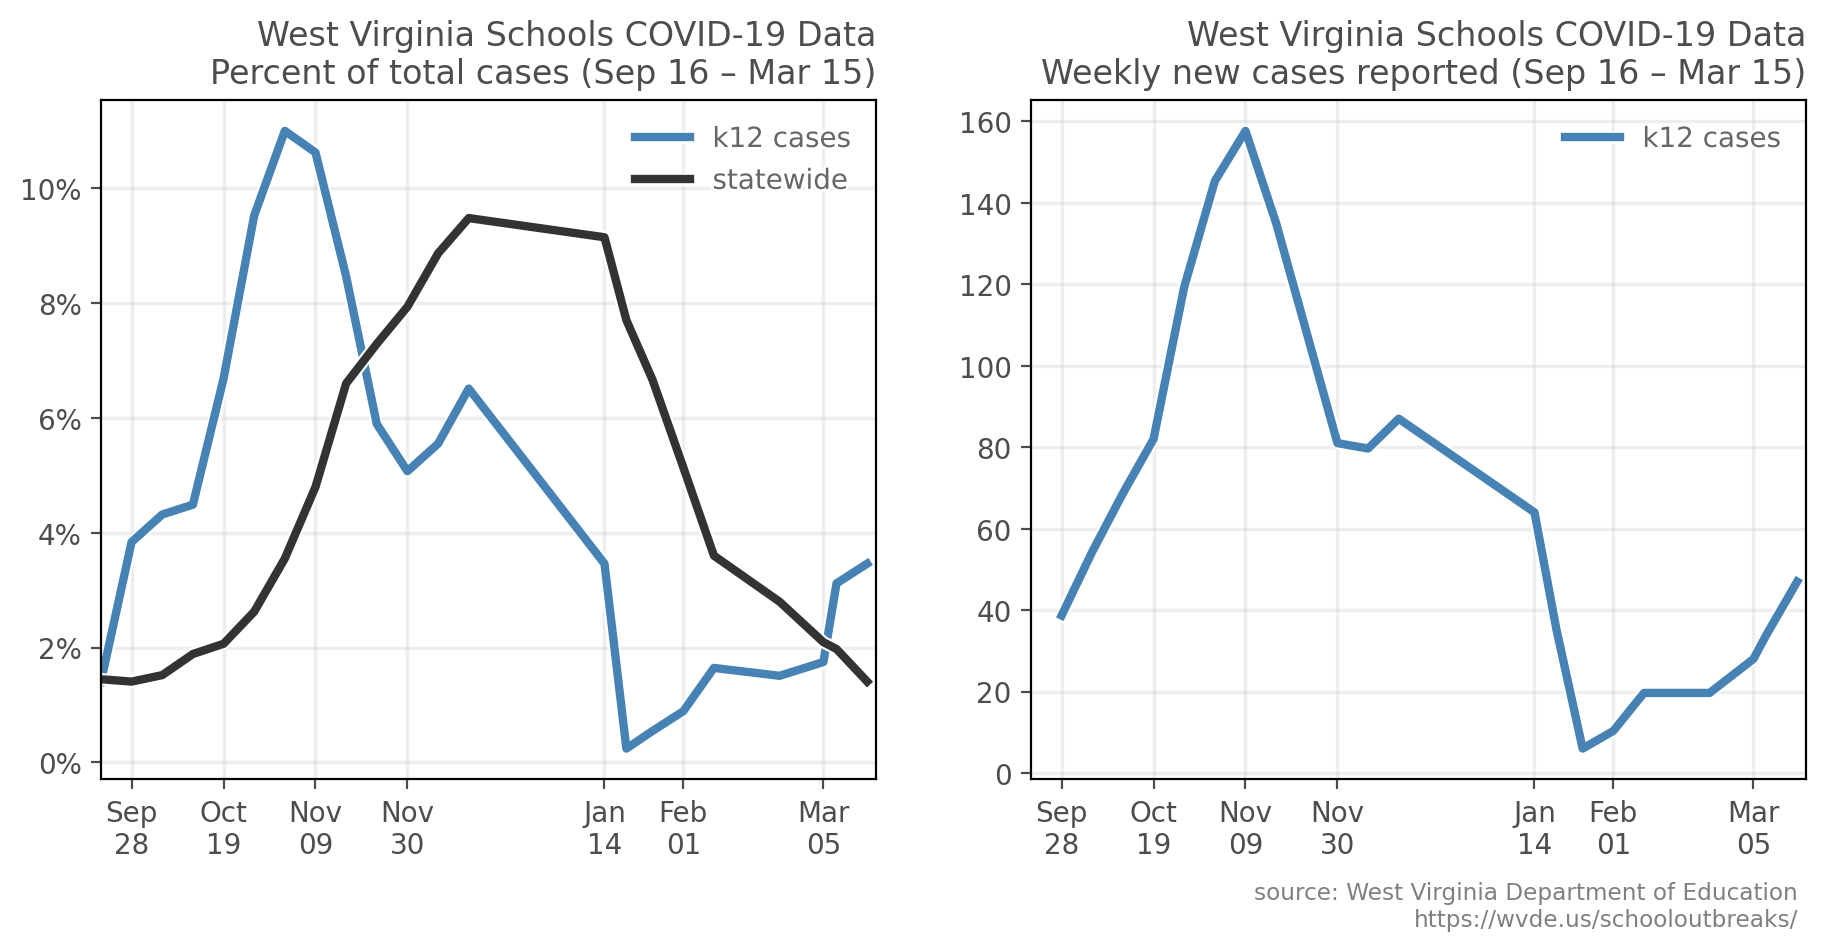

In [40]:
lw = 3
fig, ax = plt.subplots(1,2,figsize=(11,4.5),dpi=200)

labs_tx = ['k12 cases','statewide']
cols = ['steelblue','.2']
for ci, col in enumerate(['new_cases','new_cases_state']):
    xvals_i = [date_dict[i] for i in wv_dfg['date'].values]
    yvals_i = wv_dfg[col].rolling(window=2).mean().values
    ax[0].plot(xvals_i, yvals_i/np.nansum(yvals_i), label=labs_tx[ci], lw=lw, color=cols[ci],
            path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                          path_effects.Normal()])
    if ci < 1:
        yvals_i = wv_dfg[col].rolling(window=3).mean().values
        ax[1].plot(xvals_i, yvals_i, label=labs_tx[ci], lw=lw, color=cols[ci],
                path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                              path_effects.Normal()])



dates = wv_dfg['date'].values[2::3]
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))
tlabs = ['Percent of total cases '+\
              '(%s %s – %s %s)'%(month_dict[wv_dfg['date'].min()[5:7]],
                                 wv_dfg['date'].min()[8:],
                                 month_dict[districts_df_g['date'].max()[5:7]],
                                 wv_dfg['date'].max()[8:]),
        'Weekly new cases reported '+\
              '(%s %s – %s %s)'%(month_dict[wv_dfg['date'].min()[5:7]],
                                 wv_dfg['date'].min()[8:],
                                 month_dict[wv_dfg['date'].max()[5:7]],
                                 wv_dfg['date'].max()[8:]),]

for ai,a in enumerate(fig.axes):
    a.set_xticks([date_dict[i] for i in dates])
    a.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates])
    l = a.legend(loc=1, ncol=1, framealpha=0)
    for text in l.get_texts():
        text.set_color('.4')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w'),
                               path_effects.Normal()])

    a.tick_params(labelcolor='.3', color='.3')
    a.grid(linewidth=1.25,color='.75',alpha=0.25)
    a.set_title('West Virginia Schools COVID-19 Data\n'+tlabs[ai], x=1,color='.3',ha='right')
    a.set_xlim(date_dict[wv_dfg['date'].min()]+5,
                date_dict[wv_dfg['date'].max()]+2)

ax[1].text(0.99,-0.15,'source: West Virginia Department of Education\n'+\
        'https://wvde.us/schooloutbreaks/',
        color='.5',fontsize='small', va='top', ha='right', transform=ax[1].transAxes)


plt.savefig('../figs/pngs/westvirginia_k12_studentstaff.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/westvirginia_k12_studentstaff.pdf',bbox_inches='tight')
plt.show()

# Wisconsin 
Not available at this time		COVID-19 Historical Data by School District

https://data.dhsgis.wi.gov/datasets/covid-19-historical-data-by-census-tract

https://data.dhsgis.wi.gov/datasets/covid-19-historical-data-by-school-district?orderBy=DATE&orderByAsc=false




In [458]:
url_xi = 'https://opendata.arcgis.com/datasets/5f891462bfea41d3a0477a6cd62cd450_14.geojson'
with urllib.request.urlopen(url_xi) as url_i:
    wi_page_i = json.loads(url_i.read().decode())

wi_df = pd.DataFrame([x['properties'] for x in wi_page_i['features']])
wi_df['DATE'] = wi_df['DATE'].str[:10]

<AxesSubplot:>

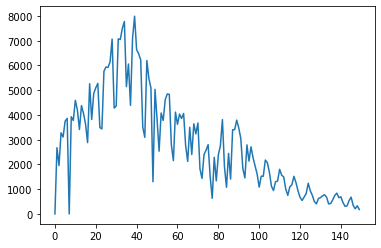

In [461]:
wi_df.groupby('DATE').agg({'POS_NEW':'sum'}).reset_index()['POS_NEW'].plot()

# Wyoming
Not available at this time		Not available at this time		